In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(first_level=1)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import IPython
from tqdm import tqdm_notebook, tqdm
from scipy.spatial import ConvexHull
import cvxpy as cp

from sklearn import datasets,linear_model
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
BIG_START = time.time()

# Introduction


**Nonnegative Matrix Factorization**

Unsupervised learning algorithms such as principal components analysis and vector quantization can be understood as factorizing a data matrix subject to different constraints. Nonnegative Matrix Factorization (NMF) is a popular approach for selecting features in data, based on a factorization in two full-rank matrices for a given rank lower than dimensions of interest matrix.

It is notoriously difficult to solve the NMF problem. Vavasis showed that NMF is NP-hard and that it is NP-complete to decide whether a matrix admits a rank-$r$ nonnegative factorization <br/>_(S. A. Vavasis. On the complexity of nonnegative matrix factorization.SIAM Journal on Opti-mization, 20(3) :1364-1377, 2009)_

In this notebook, first we investigate different algorithms linked to different paradigms which appeared as the research progressed. To highlight different characterizations of these algorithms we use simulated datasets, following the simplest case exposed by Bittorf in *'Factoring nonnegative matrices with linear programs-2012'*, for which exact NMF exists for a known rank $r$.Then we compare on similar toy datasets our algorithms performances in terms of computing time and precision (whose subjective definition will be brought further). Finally we show how NMF can be used for regression task (similar to classification) and discuss how it could be modified for other machine learning tasks.

**Toy dataset ( simplified )**

We consider $f$ as number of features, $n$ as number of observations and $r$ as factorization rank, satisfying $r < f \leq n$.

- sample r rows (called hott topics) uniformly from the unit simplex in $\mathbf{R}^n$
- duplicate these topics d times. Simplified case considers $d=0$.
- generate $f- r(d+1)$ rows to be random convex combinations of the hott topics, to form X.
- Add noise with $ ||.||_{\infty, 1} $ error bounded by $\eta \frac{\alpha^2}{20+13\alpha}$( see further ). Simplified case is without noise added.





In [3]:
#Here we implemented complete toy dataset 
def compute_alpha(X):
    
    r,n=X.shape
    """
    inputs:
    - X:(numpy array) matrix containing our hott_topics
    output:
    -alpha:(float) corresponding to the minimal distance of each hott topic to the convexhull of others
    """
    alphas=[]
    for i in range(r):
        Thetas = cp.Variable(rows=r-1, cols=1)
        obj = cp.Minimize(cp.norm(X[i,]-(Thetas.T*(np.delete(X,i,0))).T, 1))
        constraints = [Thetas >= 0, cp.sum_entries(Thetas)==1]
        prob = cp.Problem(obj, constraints)
        _ = prob.solve()
        thetas = np.array(Thetas.value)
        alphas.append(np.linalg.norm(X[i]- np.sum(thetas*np.delete(X,i,0),axis=0),ord=1))
    return(min(alphas))
def random_convex_combination(X):
    r,n=X.shape
    indexes=np.unique(np.random.randint(r,size=r))
    combinations = np.random.uniform(low=1,high=5, size=indexes.shape[0])
    convex_combinations= combinations/ np.sum(combinations)
    return(np.sum(X[indexes]* convex_combinations[:,np.newaxis], axis=0))

def create_matrix_simulation(r,f,n,d,eta):#epsilon because for now we can't compute alpha
    # V : non-negative matrix to factorize
    V = np.zeros((f,n))
    #X corresponding to our hott_topics
    X = np.random.uniform(low=1, high= 5,size = (r,n))
    X = (X.T/np.sum(X, axis = 1)).T
    alpha=compute_alpha(X)
    epsilon=alpha**2/(20+13*alpha)
    #we set first rows of V with duplicated hott topics
    V[:(d+1)*r,]= np.repeat(X,repeats=d+1, axis=0 )
    # others are random convex combination of hott_topics
    V[(d+1)*r:,]= np.array([random_convex_combination(X) for i in range(f-r*(d+1))])
    # Add bounded noise to satisfy inegality with infinity,1-norm
    noise= np.random.uniform(low=0, high=eta*epsilon/n, size=(f,n))
    return(V+noise,alpha)

# I. Theorical results and implementations

## I.1) Non-negative Matrix Factorization based on two-block coordinate descent 

(Framework: *The Why and How of NMF - N.Gillis (2014)*https://arxiv.org/pdf/1401.5226.pdf)

Given a non-negative matrix $X \in \mathbb{R}_{+}^{f*n}$ , algorithms aim to find non-negative matrices $F \in \mathbb{R}_{+}^{f*r}$ and $W \in \mathbb{R}_{+}^{r*n}$, which might respectively be considered as 'weights' and 'features', such as $X \approx FW$. 
Commonly, frobenius norm (l2 norm) is used to quantify approximation which leads to the following problem formulation:
$$\min_{F,W \geq 0} G(F,W) = \min_{F,W \geq 0} \frac{1}{2}||X-FW||_F^2   \qquad (1)$$

Problem (1) is not convex, but subproblem in one factor is convex therefore most researches initially used two-block coordinate descent scheme (exact or inexact) to alternatively optimize over one of the two factors.

Most of the advances made by these methods are initially based on first-order optimality conditions (FOOC) of (1): 

$$ F \geq 0, \quad \nabla_FG = FWW^T - XW^T \geq 0, \quad F \circ \nabla_FG = 0\\
W \geq 0, \quad \nabla_WG= F^TFW - F^TX \geq, \quad W \circ \nabla_W G=0$$

### I.1.a) Multiplicative Updates(MU): Diagonally rescaled gradient descent 

Daniel D.Lee & H.Sebastian Seung (2001) https://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf

They define multiplicative update rules to solve NFM problem under two different metrics(Frobenius norm and an adaptated Kullback-Leibler divergence), exploration in our project focuses on first metric:
    
**Theorem** : The Euclidean distance is nonincreasing under the update rules:
$$W_{(t+1)} \leftarrow W_{(t)} * \frac{F_{(t)}^T.X}{F_{(t)}^T.F_{(t)}.W_{(t)}} \qquad             F_{(t+1)} \leftarrow F_{(t)}* \frac{X.W_{(t+1)}^T}{F_{(t)}.W_{(t+1)}.W_{(t+1)}^T}$$
The Euclidean distance is invariant under these updates iif $F$ and $W$ are at a stationary point of the distance. 


Authors made a comparison between multiplicative and usual additive update rules. In particular, usual gradient descent reduces $W \rightarrow G(.,W)$ with update:
$$ W \leftarrow W + \eta \circ [F^TX - F^TFW], \text{ with, } \eta= \frac{W}{F^TFW}$$


**proof main points**: This proof is based on the majorization-minimization framework. They introduce $\hat{G}$  an auxialiary function for $G$ and take advantage that a minimization framework over $\hat{G}$ implies decrease of $G$ along an axis. 

Specifically, for $W$ optimization, if $K(h^t)$ is the diagonal matrix such as $K_{ab}(h^t)= \delta_{ab}\frac{(F^TFh^t)_a}{h_a^t}$, then
$$ \hat{G}(h,h^t) = \tilde{G}(h^t) + (h-h^t)^T\nabla \tilde{G}(h^t) + \frac{1}{2}(h-h^t)^TK(h^t)(h-h^t)$$
is an auxialiary function for 
$$ \tilde{G}(h^t)= G(F,h^t)$$
Same arguments can be applied reversing roles of $F$ and $W$.

**Therefore, this theorem guarantees to find at least locally optimal solutions with these update rules, with uninvestigated assumptions that all considered denominators are diffent to zero.**

So in order to satisfy first-order optimality conditions(FOOC), for each entry of W, these updates either 
- (i) increase it if its partial derivative is negative
- (ii) decrase it if its partial derivative is positive
- (iii) leave it unchanged if its partial derivative is equal to zero. <br/>


If an entry of W is null, these updates cannot modify it but it is possible that its partial derivative is negative, which is contradictory with FOOC. 

Several techniques have fixed this issue, here we make use of the one proposed by N.Gillis & F.Glineur in *Nonnegative Factorization and
The Maximum Edge Biclique Problem (2008)*(https://arxiv.org/pdf/0810.4225.pdf) which used a small positive lower bound for the entries of W and H


**Theorem - Gillis & Glineur 2008** For any constant $\delta >0$, $X \geq 0$ and any $(F,W) \geq \delta$, $||X-FW||_F$ is nonincreasing under 
$$ F \leftarrow max( \delta, F \circ \frac{XW^T}{FWW^T}) , \qquad W \leftarrow max( \delta, W \circ \frac{F^TX}{F^TFW})$$

**Drawbacks**: 


- Complexity of updates for one iteration:  $ W \rightarrow O(frn +r^2(f+n) + rn),   F \rightarrow O(frn +r^2(n + f) +rf )$ in terms of elementary operations.
- Convergence speed depends on initializations of $F$ and $W$
- Globally, converges very slowly, especially with dense matrices $X$.


In [4]:
####### Euclidean Distance optimization ########

def LeeSeung_MU(X,r,F_init,W_init,steps,goal):
    """Inputs:
    - X:(numpy matrix) non-negative matrix to factorize
    - r:(int) factorization rank
    - F_init:(numpy matrix/ str) initialization for F matrix. If F_init='0' will be randomly initialized within the function.
    - W_init:(numpy matrix) initialization for W matrix.
    - steps:(int) number of updates if no goal is targeted. If a goal is targeted, corresponds to max time authorized to reach it
    - goal:(positive float) targeted precision. If goal=-1 won't target a precision.
           
      Outputs:
    - distances:(list) evolution of frobenius norm through time
    - F:(numpy matrix) found F
    - W:(numpy matrix) found W"""
    distances=[]
    f,n=X.shape
    #We set F and W as random non-negative matrices
    if F_init=='0':
        F=np.random.uniform(low=10**(-16), high= 1, size=(f,r))
        W=np.random.uniform(low=10**(-16), high= 1, size=(r,n))
    else:
        F,W=F_init,W_init
    if goal==-1:
        for step in range(steps):
            distances.append(np.linalg.norm(X - np.dot(F,W), ord='fro'))
            W=W* ( np.dot(F.T, X) / np.dot(np.dot(F.T,F),W))
            F=F* (np.dot(X, W.T) / np.dot(np.dot(F, W), W.T))
    else:
        d=np.inf
        start=time.time()
        while (d>goal) and (time.time()-start < steps):
            W=W* ( np.dot(F.T, X) / np.dot(np.dot(F.T,F),W))
            F=F* (np.dot(X, W.T) / np.dot(np.dot(F, W), W.T))
            d=np.linalg.norm(X - np.dot(F,W), ord='fro')
            distances.append(d)
    return(distances,F,W)

def MU_update(X,F,W,delta_matrix):
    """Inputs:
    - X:(numpy matrix) non negative matrix to factorize
    - F:(numpy matrix) matrix to update
    - W:(numpy matrix) matrix needed for update
    - delta_matrix:(numpy matrix) matrix of delta to solve convergence issue/ depends on considered update
        Outputs:
    - (numpy matrix) result of the update """
    A=np.dot(X,W.T)
    B=np.dot(W,W.T)
    C=np.dot(F,B)
    return np.maximum(delta_matrix, F*(A/C))
def GillisGlineur_MU(X,r,F_init,W_init,delta,steps,goal):
    """Inputs:
    - X:(numpy matrix) non-negative matrix to factorize
    - r:(int) factorization rank
    - F_init:(numpy matrix/ str) initialization for F matrix. If F_init='0' will be randomly initialized within the function.
    - W_init:(numpy matrix) initialization for W matrix.
    - steps:(int) number of updates if no goal is targeted. If a goal is targeted, corresponds to max time authorized to reach it
    - goal:(positive float) targeted precision. If goal=-1 won't target a precision.
           
      Outputs:
    - distances:(list) evolution of frobenius norm through time
    - F:(numpy matrix) found F
    - W:(numpy matrix) found W"""
    distances=[]
    f,n=X.shape
    
    #We set F and W as random non-negative matrices
    if F_init=='0':
        F=np.random.uniform(low=delta, high= 1, size=(f,r))
        W=np.random.uniform(low=delta, high= 1, size=(r,n))
    else:
        F,W=F_init,W_init
    delta_F= delta*np.ones(shape=(f,r))
    delta_W_transposed= delta*np.ones(shape=(n,r))
    if goal==-1:
        for step in range(steps):
            distances.append(np.linalg.norm(X - np.dot(F,W), ord='fro'))
            F=MU_update(X,F,W,delta_F)
            W=MU_update(X.T,W.T,F.T,delta_W_transposed).T #update W using symmetry of update rule
    else:
        d=np.inf
        start=time.time()
        while (d>goal) and (time.time()-start < steps):
            F=MU_update(X,F,W,delta_F)
            W=MU_update(X.T,W.T,F.T,delta_W_transposed).T
            d=np.linalg.norm(X - np.dot(F,W), ord='fro')
            distances.append(d)
    return(distances,F,W)


For these two algorithms we illustrate drawbacks determined earlier. For different dimensions, we visualize how factorization precision evolves through iterations (fixing two stopping criterion: a maximum computing time or a precision goal ) for a given matrix with different initializations of $F$ and $W$. (Similar experiments will be done for other two-block descent gradient algorithms)

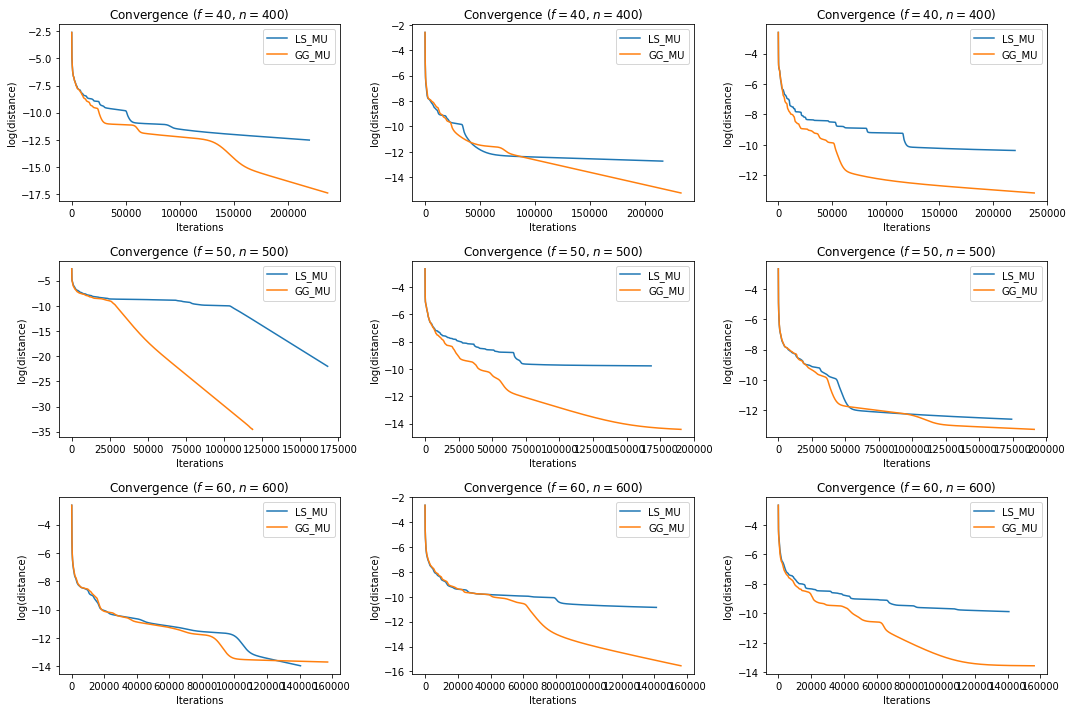

In [5]:
dimensions=[(40,400),(50,500),(60,600)]
number_of_init=3; r=5; max_time=20

plt.figure(figsize=(15,10))
for j in range(len(dimensions)):
    f,n=dimensions[j]
    X,alpha=create_matrix_simulation(r,f,n,0,0)
    list_F_init=[np.random.uniform(low=10**(-16), high= 1, size=(f,r)) for _ in range(number_of_init)]
    list_W_init=[np.random.uniform(low=10**(-16), high= 1, size=(r,n)) for _ in range(number_of_init)]

    for i in range(number_of_init):
        distances1,F1,W1= LeeSeung_MU(X,r,list_F_init[i],list_W_init[i], steps=max_time, goal=10**(-15))
        distances2,F2,W2= GillisGlineur_MU(X,r,list_F_init[i],list_W_init[i],10**(-16),steps=max_time, goal=10**(-15))
        plt.subplot(len(dimensions), number_of_init, j*number_of_init +i+1)
        plt.plot(range(len(distances1)), np.log(distances1))
        plt.plot(range(len(distances2)), np.log(distances2))
        plt.legend(['LS_MU','GG_MU'])
        plt.title('Convergence ($f={0}$, $n={1})$'.format(f,n))
        plt.xlabel('Iterations')
        plt.ylabel('log(distance)')
plt.tight_layout()
plt.show()

Then we empirically verify that:

- Convergence depends on initializations
- In most cases, modification provided by Gillis & Glineur allows a slightly faster convergence. Although all these experiments are stopped by our computing time limit criterion, which induces a rather slow convergence speed.

### I.1.b) Hierarchical Alternating Least Squares


These algorithms solve the non-negative least squares subproblem using an exact coordinate descent method.  In fact, we can use another optimization scheme considering successively each rank-one factor $F_{:,k}W_{k,:}$ while keeping the rest of the variables fixed, which can be expressed as 
$$ X \approx F_{:,k}W_{k,:} + \sum_{i \neq k}F_{:,i}W_{i,:} \Leftrightarrow F_{:,k}W_{k,:} \approx X - \sum_{i \neq k}F_{:,i}W_{i,:} = R_k$$
where matrix $R_k$ is called the $k^{th}$ residual matrix. 
Ideally we would like to find an optimal rank-one factor conducting to an optimization in two variables $F_{:,k}, W_{k,:} \geq 0$. However one can make use of an alternating scheme for which closed form solutions can be easily computed:
$$ F_{:,k}^\star = argmin_{F_{:,k} \geq 0} ||R_k - F_{:,k}W_{k,:}||^2_F = \max(0, \frac{R_kW_{k,:}^T}{||W_{k,:}||^2_2}) \\
W_{k,:}^\star = argmin_{W_{k,:} \geq 0} ||R_k - F_{:,k}W_{k,:}||^2_F = \max(0, \frac{F_{:,k}^TR_k}{||F_{:,k}||^2_2}) 
$$


A potential issue here is that one of the vectors $F_{:,k}$ or $W_{k,:}$ may become equal to zero, then associated rank-one factor will also be zero which can lead to numerical instabilities and a rank-deficient approximation. 
As suggested in N.Gillis and F.Glineur (2008) we can consider a $1 >> \delta >0$ to restrain last subproblems to $F_{:,k}, W_{k,:} \geq \delta$, which lead to the the modified closed-form update rules:
$$F_{:,k}^\star =\max(\delta, \frac{R_kW_{k,:}^T}{||W_{k,:}||^2_2}) \quad \text{and} \quad W_{k,:}^\star = \max(\delta, \frac{F_{:,k}^TR_k}{||F_{:,k}||^2_2}) $$
They proved that this variant of the algorithm is now well-defined in all situations and converges to a stationary point.

**Drawbacks**
(Almost as MU)
- Complexity of updates for one iteration:  $ W \rightarrow O(frn +r^2(f+n) + rn) ,  F \rightarrow O(frn +r^2(n + f) +rf )$ in terms of elementary operations. We need to specify more precisely complexity to see a slight improvement (detailed further)
- Convergence speed depends on initializations of $F$ and $W$
- Globally, converges very slowly, especially with dense matrices $X$. However, in practice show faster convergence than MU.


In [6]:
#HALS code

#update of F(t+1)= update(X, F(t),W(t)) and by symmetry W(t+1)= update(X^T, W(t)^T, F(t+1)^T)^T
def HALS_update(X,F,W,delta_axis):
    """Inputs:
    - X:(numpy matrix) non negative matrix to factorize
    - F:(numpy matrix) matrix to update
    - W:(numpy matrix) matrix needed for update
    - delta_axis:(numpy matrix) matrix of delta to solve convergence issue/ depends on considered update
        Outputs:
    - (numpy matrix) result of the update """
    f,n=X.shape
    r=F.shape[1]
    A=np.dot(X,W.T)
    B=np.dot(W,W.T)
    for k in range(r):
        C_k= np.sum([B[i,k]* F[:,i] for i in range(r) if i !=k],axis=0).reshape(f,1)
        component= (A[:,k].reshape(f,1)-C_k)/B[k,k]
        F[:,k]= np.maximum(delta_axis, component.reshape(f,))
    return(F)
def GillisGlineur_HALS(X,r,F_init,W_init,delta,steps,goal):
    """Inputs:
    - X:(numpy matrix) non-negative matrix to factorize
    - r:(int) factorization rank
    - F_init:(numpy matrix/ str) initialization for F matrix. If F_init='0' will be randomly initialized within the function.
    - W_init:(numpy matrix) initialization for W matrix.
    - steps:(int) number of updates if no goal is targeted. If a goal is targeted, corresponds to max time authorized to reach it
    - goal:(positive float) targeted precision. If goal=-1 won't target a precision.
           
      Outputs:
    - distances:(list) evolution of frobenius norm through time
    - F:(numpy matrix) found F
    - W:(numpy matrix) found W"""
    distances=[]
    f,n=X.shape
    if F_init=='0':
        F=np.random.uniform(low=delta, high= 1, size=(f,r))
        W=np.random.uniform(low=delta, high= 1, size=(r,n))
    else:
        F,W=F_init,W_init
    delta_column=delta*np.ones(shape=(f,))
    delta_row=delta*np.ones(shape=(n,))
    if goal==-1:
        for step in range(steps):
            F=HALS_update(X,F,W,delta_column)
            W=HALS_update(X.T,W.T,F.T,delta_row).T
            distances.append(np.linalg.norm(X-np.dot(F,W),ord='fro'))
    else:
        d=np.inf
        start=time.time()
        while (d>goal) and (time.time()-start < steps):
            F=HALS_update(X,F,W,delta_column)
            W=HALS_update(X.T,W.T,F.T,delta_row).T
            d=np.linalg.norm(X-np.dot(F,W),ord='fro')
            distances.append(d)
    return(distances,F,W)

Here we show how performs this HALS algorithm for different initializations and dimensions with the toy dataset.

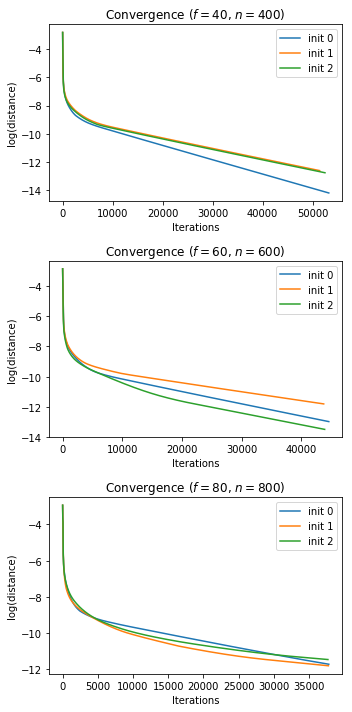

In [7]:
dimensions=[(40,400),(60,600),(80,800)]
number_of_init=3; r=5; max_time=20

plt.figure(figsize=(5,10))
for j in range(len(dimensions)):
    f,n=dimensions[j]
    X,alpha=create_matrix_simulation(r,f,n,0,0)
    list_F_init=[np.random.uniform(low=10**(-16), high= 1, size=(f,r)) for _ in range(number_of_init)]
    list_W_init=[np.random.uniform(low=10**(-16), high= 1, size=(r,n)) for _ in range(number_of_init)]
    plt.subplot(len(dimensions), 1, j+1)
    for i in range(number_of_init):
        distances,F,W= GillisGlineur_HALS(X,r,list_F_init[i],list_W_init[i],10**(-16), steps=max_time, goal=10**(-15))
        plt.plot(range(len(distances)), np.log(distances))
    plt.legend(['init %i'%i for i in range(number_of_init)])
    plt.title('Convergence ($f={0}$, $n={1}$)'.format(f,n))
    plt.xlabel('Iterations')
    plt.ylabel('log(distance)')
plt.tight_layout()
plt.show()

**Analysis**:

- HALS is also sensitive to initializations
- All these experiments of optimization are stopped by our computing time limit of 10 seconds, which still induce a rather slow convergence speed.

### I.1.c) Accelerated MU and HALS

N.Gillis and F.Glineur analysed in their article *Accelerated Multiplicative Updates and HALS Algorithms for NMF (2011)*(https://arxiv.org/pdf/1107.5194.pdf), different ways to fasten convergence of any algorithms based on two blocks coordinate descent.
First they made an analysis of the computational cost of factor updates. In order to make their analysis valid for both dense and sparse input matrices, they introduced a parameter $K$ denoting the number of nonzero entries in matrix $X$. They assumed that NMF achives compression, which is often a requirement in practice. This means that storing $F$ and $W$ must be cheaper than storing $X$: roughly speaking, the number of entries in $F$ and $W$ must be smaller than the number of nonzero entries in $X$, i.e, $r(m+n) \leq K$.
Like usually number of features is inferior to number of observations, they investigate stopping criterions while making multiple descent steps over $F$ before an update of $W$( which is "bigger"). Note that in our previous algorithms, we update once $F$ and $W$ at each timestep.

Then, they discussed two different strategies for choosing the number of inner iterations: the first uses a fixed number of inner iterations determined by the flop counts, while the second is based on a dynamic stopping criterion that checks the difference between two consecutive iterates.


<u> **Fixed Number of Inner Iterations:** </u>

**MU update for F**

1. $A=XW^{(k)T}       \quad \rightarrow 2Kr$ flops
2. $B=W^{(k)}W^{(k)T} \quad \rightarrow 2nr^2$ flops
3. $C=F^{(k)}B \quad \rightarrow 2fr^2$ flops
4. $F^{(k+1)}=F^{(k)} \circ \frac{A}{C} \quad \rightarrow 2fr$ flops (and more considering comparison to $\delta$)

$\Rightarrow$ Total: $2r(K +r(n+f) + m)$

**HALS update for F**

1. $A=XW^{(k)T}       \quad \rightarrow 2Kr$ flops
2. $B=W^{(k)}W^{(k)T} \quad \rightarrow 2nr^2$ flops
3. for $i= 1, ... , r$ do
4. $ \quad C_{:,i} = \sum_{l=1}^{i-1}F_{:,l}^{(k+1)}B_{l,i} + \sum_{l=i+1}^{r}F_{:,l}^{(k)}B_{l,i} \quad \rightarrow 2f(r-1)$ flops
5. $ \quad F_{:,i}^{(k+1)} = max(\delta, \frac{A_{:,i}- C_{:,i}}{B_{i,i}}) \quad \rightarrow 3m$ flops

$\Rightarrow$ Total: $2r(K +r(n+f)) +rm $

Therefore based, on the flops counts, they estimated how expensive the first inner update of $F$ would be relatively to the next ones (ie without changing A, the most expensive, and B), which is given by the factor $\rho_F$ for a specific algorithm.
$$ \rho_{F, (MU)} \approx 1+ \frac{K+nr}{fr+f} \qquad  \rho_{F, (HALS)} \approx 1+ \frac{2K+2nr}{2fr+3f}$$
They investigated speed of convergence through a parameter $\alpha$ considering $1+\alpha \rho_F$ iterates before update of $W$.

<u> **Dynamic Stopping Criterion for Inner Iterations:**</u> 

Noting $F^{(k,l)}$ the iterate after $l$ updates of $F^{(k)}$, they stopped inner iterations as soon as
$$||F^{(k,l+1)} - F^{(k,l)}||_F \leq \epsilon ||F^{(k,1)} - F^{(k,0)}||_F$$
Through investigation of parameter $\epsilon$ they empirically concluded this method to be slower than the first one.

<u> **hybrid stopping criterion** </u> 

Therefore, by combining both, they introduce a new method which finally very slightly outperformed flops based algorithm in terms of convergence for each global timestep. 

**Drawbacks**

- These algorithms are still sensible to initializations of $F$ and $W$.
- In practice, they demonstrate high improvements of convergence speed.

In [8]:
############# Hybrid MU code ##############
def MU_shorten_update(X,F,W,delta_matrix,A,B):
    """Inputs:
    - X:(numpy matrix) non negative matrix to factorize
    - F:(numpy matrix) matrix to update
    - W:(numpy matrix) matrix needed for update
    - delta_axis:(numpy matrix) matrix of delta to solve convergence issue/ depends on considered update
    - A:(numpy matrix) matrix A as described above
    - B:(numpy matrix) matrix B as described above
    Outputs:
    - (numpy matrix) result of the update """
    C=np.dot(F,B)
    return np.maximum(delta_matrix, F*(A/C))
    
def GillisGlineur_MU_hybrid(X,r,F_init,W_init,delta,steps,alpha,epsilon,goal):
    """Inputs:
    - X:(numpy matrix) non-negative matrix to factorize
    - r:(int) factorization rank
    - F_init:(numpy matrix/ str) initialization for F matrix.
        If F_init='0' will be randomly initialized within the function.
    - W_init:(numpy matrix) initialization for W matrix.
    - steps:(int) number of updates if no goal is targeted. 
        If a precision is targeted, corresponds to max time authorized to reach it
    - alpha:(float) regularization for flops criterion
    - epsilon:(float) regularization for dynamic criterion
    - goal:(positive float) targeted precision. 
        If goal=-1 won't target a precision.
           
      Outputs:
    - distances:(list) evolution of frobenius norm through time
    - F:(numpy matrix) found F
    - W:(numpy matrix) found W"""
    distances=[]
    f,n=X.shape
    if F_init=='0':
        F=np.random.uniform(low=delta, high= 1, size=(f,r))
        W=np.random.uniform(low=delta, high= 1, size=(r,n))
    else:
        F,W=F_init,W_init
    delta_F= delta*np.ones(shape=(f,r))
    delta_W_transposed= delta*np.ones(shape=(n,r))
    rho_F= 1+(f*n+n* r)/(f*r+f)
    if goal==-1:
        for step in tqdm(range(steps)):
            A=np.dot(X,W.T)
            B=np.dot(W,W.T)
            prev_F=F.copy()
            first_update_F=MU_shorten_update(X,F,W,delta_F,A,B)
            dynamic_criterion=epsilon*np.linalg.norm(prev_F-F,ord='fro')
            #We need to compute frobenius norm between init and first update for dynamic stopping criterion
            for substep in range(int(1+alpha*rho_F)):
                prev_F=F.copy()
                F=MU_shorten_update(X,F,W,delta_F,A,B)
                if np.linalg.norm(prev_F-F,ord='fro') <= dynamic_criterion:
                    break
            W=MU_update(X.T,W.T,F.T,delta_W_transposed).T
            distances.append(np.linalg.norm(X-np.dot(F,W),ord=2))
    else:
        d=np.inf
        start=time.time()
        while (d>goal) and (time.time()-start < steps):
            A=np.dot(X,W.T)
            B=np.dot(W,W.T)
            prev_F=F.copy()
            F=MU_shorten_update(X,F,W,delta_F,A,B)
            dynamic_criterion=epsilon*np.linalg.norm(prev_F-F,ord='fro')
            #We need to compute frobenius norm between init and first update for dynamic stopping criterion
            for substep in range(int(1+alpha*rho_F)):
                prev_F=F.copy()
                F=MU_shorten_update(X,F,W,delta_F,A,B)
                if np.linalg.norm(prev_F-F,ord='fro') <= dynamic_criterion:
                    break
            W=MU_update(X.T,W.T,F.T,delta_W_transposed).T
            d=np.linalg.norm(X-np.dot(F,W),ord=2)
            distances.append(d)
    return(distances,F,W)

############# hybrid HALS code ##############

#update of F(t+1)= update(X, F(t),W(t)) and by symmetry W(t+1)= update(X^T, W(t)^T, F(t+1)^T)^T
def HALS_shorten_update(X,F,W,delta_axis,A,B):
    """Inputs:
    - X:(numpy matrix) non negative matrix to factorize
    - F:(numpy matrix) matrix to update
    - W:(numpy matrix) matrix needed for update
    - delta_axis:(numpy matrix) matrix of delta to solve convergence issue/ depends on considered update
    - A:(numpy matrix) matrix A as described above
    - B:(numpy matrix) matrix B as described above
    Outputs:
    - (numpy matrix) result of the update """
    f,n=X.shape
    r=F.shape[1]
    for k in range(r):
        C_k= np.sum([B[i,k]* F[:,i] for i in range(r) if i !=k],axis=0).reshape(f,1)
        component= (A[:,k].reshape(f,1)-C_k)/B[k,k]
        F[:,k]= np.maximum(delta_axis, component.reshape(f,))
    return(F)


def GillisGlineur_HALS_hybrid(X,r,F_init,W_init,delta,steps,alpha,epsilon,goal):
    """Inputs:
    - X:(numpy matrix) non-negative matrix to factorize
    - r:(int) factorization rank
    - F_init:(numpy matrix/ str) initialization for F matrix. If F_init='0' will be randomly initialized within the function.
    - W_init:(numpy matrix) initialization for W matrix.
    - steps:(int) number of updates if no goal is targeted. If a goal is targeted, corresponds to max time authorized to reach it
    - alpha:(float) regularization for flops criterion
    - epsilon:(float) regularization for dynamic criterion
    - goal:(positive float) targeted precision. If goal=-1 won't target a precision.
           
      Outputs:
    - distances:(list) evolution of frobenius norm through time
    - F:(numpy matrix) found F
    - W:(numpy matrix) found W"""
    distances=[]
    f,n=X.shape
    if F_init=='0':
        F=np.random.uniform(low=delta, high= 1, size=(f,r))
        W=np.random.uniform(low=delta, high= 1, size=(r,n))
    else:
        F,W=F_init,W_init
    delta_column=delta*np.ones(shape=(f,))
    delta_row=delta*np.ones(shape=(n,))
    rho_F= 1+(2*f*n+2*n* r)/(2*f*r+3*f)
    if goal==-1:
        for step in range(steps):
            A=np.dot(X,W.T)
            B=np.dot(W,W.T)
            prev_F=F.copy()
            F=HALS_shorten_update(X,F,W,delta_column,A,B)
            dynamic_criterion=epsilon*np.linalg.norm(prev_F-F,ord='fro')
            #We need to compute frobenius norm between init and first update for dynamic stopping criterion
            for substep in range(int(1+alpha*rho_F)):
                prev_F=F.copy()
                F=HALS_shorten_update(X,F,W,delta_column,A,B)
                if np.linalg.norm(prev_F-F,ord='fro') <= dynamic_criterion:
                    break
            W=HALS_update(X.T,W.T,F.T,delta_row).T
            distances.append(np.linalg.norm(X-np.dot(F,W),ord=2))
    else:
        d=np.inf
        start=time.time()
        while (d>goal) and (time.time()-start < steps):
            A=np.dot(X,W.T)
            B=np.dot(W,W.T)
            prev_F=F.copy()
            F=HALS_shorten_update(X,F,W,delta_column,A,B)
            dynamic_criterion=epsilon*np.linalg.norm(prev_F-F,ord='fro')
            #We need to compute frobenius norm between init and first update for dynamic stopping criterion
            for substep in range(int(1+alpha*rho_F)):
                prev_F=F.copy()
                F=HALS_shorten_update(X,F,W,delta_column,A,B)
                if np.linalg.norm(prev_F-F,ord='fro') <= dynamic_criterion:
                    break
            W=HALS_update(X.T,W.T,F.T,delta_row).T
            d=np.linalg.norm(X-np.dot(F,W),ord=2)
            distances.append(d)
    return(distances,F,W)

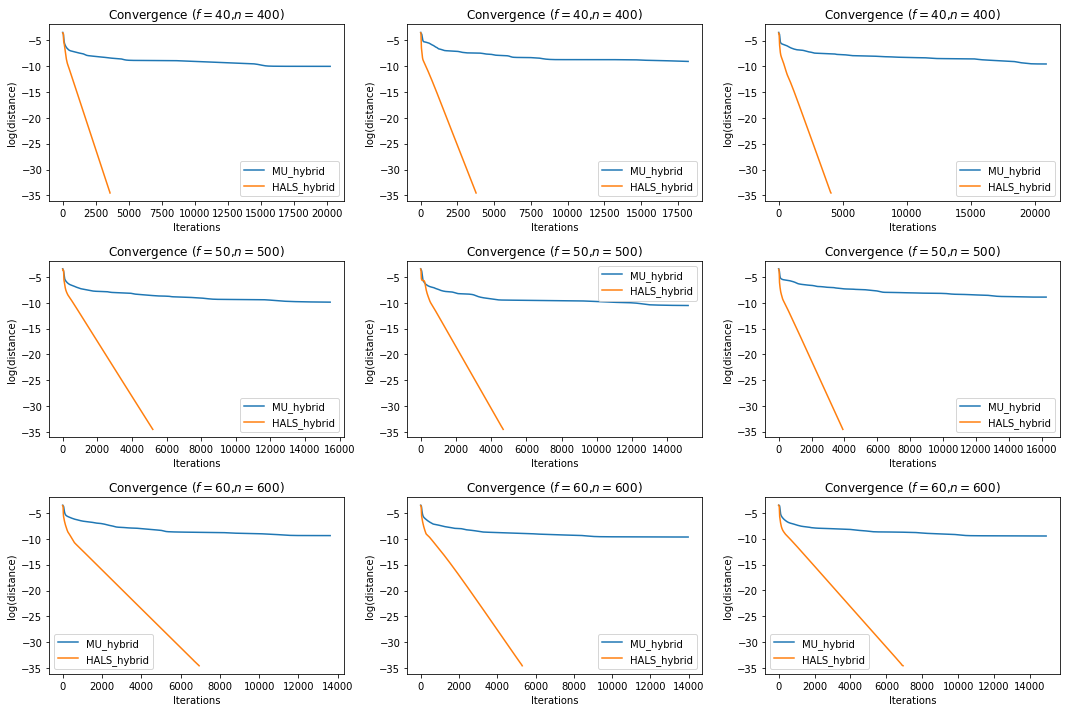

In [9]:
dimensions=[(40,400),(50,500),(60,600)]
number_of_init=3; r=5; max_time=20

plt.figure(figsize=(15,10))
for j in range(len(dimensions)):
    f,n=dimensions[j]
    X,alpha=create_matrix_simulation(r,f,n,0,0)
    list_F_init=[np.random.uniform(low=10**(-16), high= 1, size=(f,r)) for _ in range(number_of_init)]
    list_W_init=[np.random.uniform(low=10**(-16), high= 1, size=(r,n)) for _ in range(number_of_init)]
    for i in range(number_of_init):
        #MU empirical results -> alpha= 1 / epsilon=0.1
        distances1,F1,W1= GillisGlineur_MU_hybrid(X,r,list_F_init[i],list_W_init[i], 10**(-16), steps=max_time, alpha=1,epsilon=0.1, goal=10**(-15))
        #HALS empirical results -> alpha =0.5 / epsilon=0.1
        distances2,F2,W2= GillisGlineur_HALS_hybrid(X,r,list_F_init[i],list_W_init[i],10**(-16),steps=max_time,alpha=0.5,epsilon=0.1, goal=10**(-15))
        plt.subplot(len(dimensions), number_of_init, j*number_of_init +i+1)
        plt.plot(range(len(distances1)), np.log(distances1))
        plt.plot(range(len(distances2)), np.log(distances2))
        plt.legend(['MU_hybrid','HALS_hybrid'])
        plt.title('Convergence ($f={0}$,$n={1}$)'.format(f,n))
        plt.xlabel('Iterations')
        plt.ylabel('log(distance)')
plt.tight_layout()
plt.show()

**Analysis**:

- Still sensitive to initializations 
- Significative improvement of convergence speeds, especially with HALS
- Much of the difference observed between these 2 hybrid methods is due to hyperparameter tuning, not so much to radical algorithmic difference

We know that the optimal solution is to find what is called the hott topics, we will detail this notion below. In the meantime, let's just compare the results of our methods to the optimal solution for the matrix $W$, we know this optimal solution from the way we designed our toy example matrix :

In [10]:
r,f,n = [5,40,400]

F_init = np.random.uniform(low=10**(-16), high= 1, size=(f,r))
W_init = np.random.uniform(low=10**(-16), high= 1, size=(r,n))
X,alpha=create_matrix_simulation(r,f,n,0,0)

Optimal_Solution_W = X[:r,:]

distances,F,W = GillisGlineur_HALS_hybrid(X,r,F_init,W_init,10**(-16),steps=10,alpha=0.5,epsilon=0.1, goal=10**(-15))
print("Distance of HALS Hybrid recomposition to actual Nonnegative Matrix input: ", distances[-1])

Distance of HALS Hybrid recomposition to actual Nonnegative Matrix input:  9.927033477317071e-16


Let's now compare our $W$ to the optimal soolution, row by row :

In [11]:
distance_Wi = pd.DataFrame(index = ['W_'+str(i) for i in range(r)],
                           columns = ['W_'+str(i) for i in range(r)], dtype = np.float32)

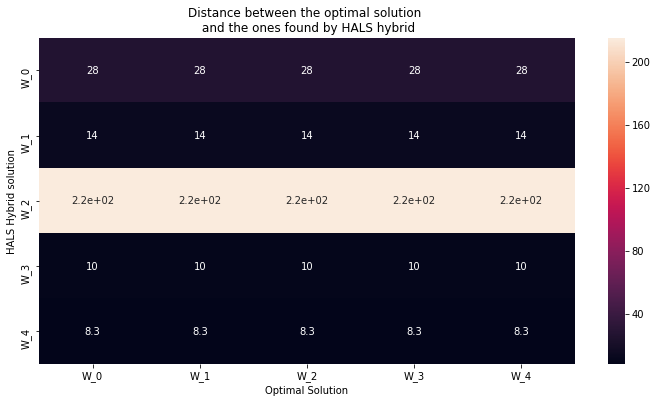

In [12]:
for i in range(r):
    HALS_hy_Wi = W[i,:]
    for j in range(r):
        optimal_Wi = Optimal_Solution_W[j,:]
        distance_Wi.iloc[i,j] = np.linalg.norm(HALS_hy_Wi-optimal_Wi)
import seaborn as sns
plt.figure(figsize = (12,6))
ax = sns.heatmap(distance_Wi, annot=True)
plt.xlabel("Optimal Solution")
plt.ylabel("HALS Hybrid solution")
plt.title("Distance between the optimal solution \n and the ones found by HALS hybrid")
plt.show()

We see a pretty big difference, this is due to the fact that our HALS_hy_W matrix is not normalized. Let's normalize it and re-compare them :

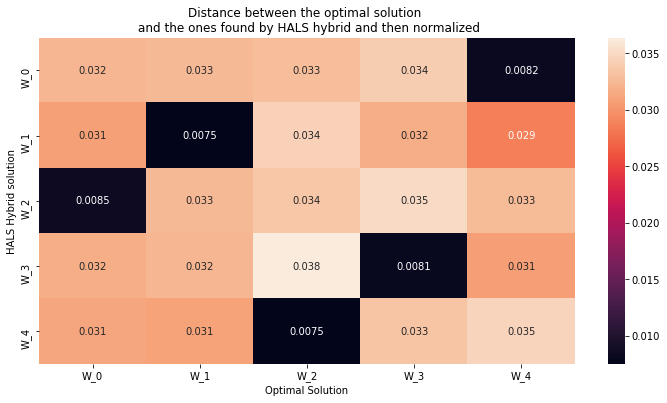

In [13]:
for i in range(r):
    HALS_hy_Wi = W[i,:]/np.sum(W,axis = 1)[i]
    for j in range(r):
        optimal_Wi = Optimal_Solution_W[j,:]
        distance_Wi.iloc[i,j] = np.linalg.norm(HALS_hy_Wi-optimal_Wi)
import seaborn as sns
plt.figure(figsize = (12,6))
ax = sns.heatmap(distance_Wi, annot=True, robust  = True)
plt.xlabel("Optimal Solution")
plt.ylabel("HALS Hybrid solution")
plt.title("Distance between the optimal solution \n and the ones found by HALS hybrid and then normalized")
plt.show()

This is quite interresting, we see that each vector of our normalized HALS_hy_W matrix has a close neighbor in the set of optimal answers, and that it doesn't share this nearest neighbor with any other vectore of our HALS_hy_W matrix. this could be one appproach to use the gradient methods to do features selection, and not just features reduction.

Let's do the same comparison, but on all $X$ this time, not just the optimal solution :

In [14]:
distance_Wi = pd.DataFrame(index = ['W_'+str(i) for i in range(r)],
                           columns = ['W_'+str(i) for i in range(X.shape[0])], dtype = np.float32)

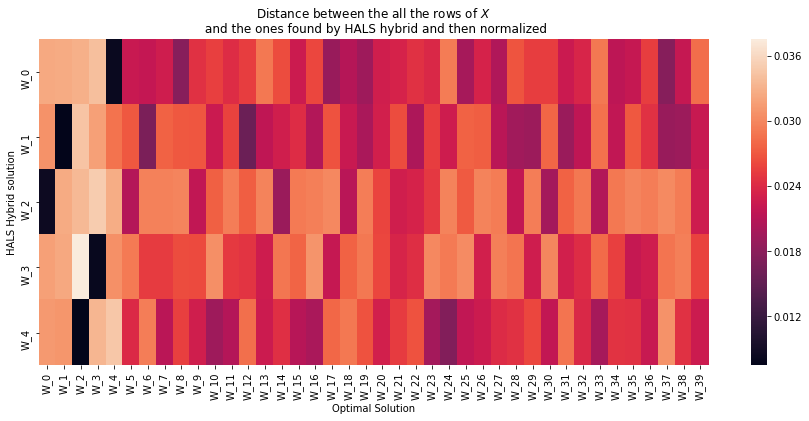

In [15]:
for i in range(r):
    HALS_hy_Wi = W[i,:]/np.sum(W,axis = 1)[i]
    for j in range(X.shape[0]):
        Xi = X[j,:]
        distance_Wi.iloc[i,j] = np.linalg.norm(HALS_hy_Wi-Xi)
import seaborn as sns
plt.figure(figsize = (15,6))
ax = sns.heatmap(distance_Wi)
plt.xlabel("Optimal Solution")
plt.ylabel("HALS Hybrid solution")
plt.title("Distance between the all the rows of $X$ \n and the ones found by HALS hybrid and then normalized")
plt.show()

It would seems that you can indeed find the hott topics with the gradient method by doing so.

In the rest of the notebook let us introduce other methods to compute NMF which will directly take advantage of the separability of the input, hence doing feature selection.

## 1.2) Near Separable NMF

**Definition :** A set of vector $\{\textbf{x}_1,...,\textbf{x}_r\} \subset \mathbb{R}^d$ is simplicial if no vector $\textbf{x}_i$ lies in the convex hull of $\{\textbf{x}_j : i\neq j \}$. The set of vector is $\alpha$-robust simplicial  if, for each $i$, the $l_1$ distance from $\textbf{x}_i$ to the convex hull $\{\textbf{x}_j : i\neq j \}$ is at least $\alpha$_.

**Definition :** A NMF $\textbf{X} = \textbf{F}\textbf{W}$ is called separable if the rows of $\textbf{W}$ are simplicial and there is a permutation matrix $\Pi$ such that : $$\Pi \, \textbf{F} =
\left[ {\begin{array}{c}
   I_r \\
   M \\
  \end{array} } \right]$$
  
The idea behind these 2 definitions is that we can indeed, find a NMF of $\textbf{X}$ efficiently if $\textbf{X}$ contains a set of $r$ rows that is simplicial and whose convex hull contains the other remaining rows. <br/>
So, to compute a separable factorization of $\textbf{X}$, we must first identify these $r$ rows. Then we can compute the weights that express the remaining rows as convex combinations of this distinguished set. We call the simplicial rows _hott_ and the corresponding features _hott topics_.

The separability assumption makes sense in several applications. For example in text mining, separability of the word-by-document matrix requires that for each topic, there exists a document only on that topic. Note that we can also assume separability document-by-word matrix (transposition) ie for each topic there exists one word used only by that topic ('anchor' word) which is a more reasonable assumption in practice.


### 1.2.a) AGKM - 2011

Theorical Results: https://arxiv.org/pdf/1111.0952.pdf

<img src="AGKM.PNG">

**Theorem**: Let $\epsilon$ and $\alpha$ be nonnegative constants satisfying $\epsilon \leq \frac{\alpha^2}{20+13\alpha}$. Let $X$ be a nonnegative data matrix. Assume $X=Y+ \Delta$ where $Y$ is a nonnegative matrix whose rows have unit l1-norm, where $Y=FW$ is a rank-$r$ separable factorization in which the rows of $W$ are $\alpha$-robust simplicial and $||\Delta||_{\infty,1} \leq \epsilon$. Then AGKM algorithm finds a rank-$r$ nonnegative factorization $\hat{F}\hat{W}$ that satisfies the error bound $||X- \hat{F}\hat{W}||_{\infty,1} \leq \frac{10\epsilon}{\alpha} + 7\epsilon$


**Drawbacks**:
- requires a priori knowledge of the parameters $\alpha$ and $\epsilon$. We can only estimate both if we know which rows are hott topics.
- Compute all distances between rows $O(f^2n)$
- Compute for each row distances to convexhull $\Omega(fn)$

In [16]:
def compute_delta(X):
    
    r,n=X.shape
    Thetas = cp.Variable(rows=r-1, cols=1)
    obj = cp.Minimize(cp.norm(X[0,:]-(Thetas.T*X[1:,]).T, 1))
    constraints = [Thetas >= 0, cp.sum_entries(Thetas)==1]
    prob = cp.Problem(obj, constraints)
    _ = prob.solve()
    thetas = np.array(Thetas.value)
    delta=np.linalg.norm(X[0]- np.sum(thetas*X[1:,],axis=0),ord=1)
    return(delta)

def compute_F(X,W):
    Z_cp = cp.Variable(rows=X.shape[0], cols=W.shape[0])
    obj = cp.Minimize(cp.max_entries(cp.sum_entries(cp.atoms.elementwise.abs.abs(X-Z_cp*W), axis = 1)))
    constraints = [Z_cp >= 0]
    prob = cp.Problem(obj, constraints)
    _ = prob.solve()
    F = np.array(Z_cp.value)
    return(F)

def AGKM(X,alpha,epsilon):
    f,n=X.shape
    #as we have an upper bound for epsilon depending on alpha, we compute it this way
    #epsilon=alpha**2/(20+13*alpha)
    R=[] #set of rows // identify hott topics
    #compute matrix distance 
    D=np.zeros(shape=(f,f))
    for i in range(f):
        for j in range(i+1,f):
            D[i,j]= np.linalg.norm(X[i]- X[j],ord=1)
            D[j,i]=D[i,j] 
    for k in range(f):
        #find the set N_k of rows that are at least 5e/(alpha+2e) from X_k
        N_k=[i for i in range(f) if D[i,k]>5*epsilon/alpha +2*epsilon]
        #compute distance delta_k of X_k from conv(Xj, j in N_k)
        if len(N_k)>0:
            delta_k=compute_delta(X[[k]+N_k])
        else:
            delta_k=0
        if delta_k>2*epsilon:
            #print(k,'added to R')
            R.append(k)
            clusters=np.array([[j for j in R[ind_i:] if (D[i,j]<= 10*epsilon/alpha +6*epsilon)] for ind_i, i in enumerate(R)])
        
    #cluster rows in R as follows: j and k are in the same cluster if D_jk <=10 e/(alpha + 6e)
    clusters=np.array([[j for j in R[ind_i:] if (D[i,j]<= 10*epsilon/alpha +6*epsilon)] for ind_i, i in enumerate(R)])

    #Choose one element from each cluster to yield W
    W=np.array([X[selected_row] for selected_row in [np.random.choice(cluster) for cluster in clusters]])
    # F=argmin ||X-ZW|| norm inf,1
    F=compute_F(X,W)
    return(F,W,R)

Since this algorithm, and the next ones as well, doesn't have a convergence profile, we will instead look at performance and time needed to compute the NMF, depending on the size of the input matrix.

In [17]:
SHAPE_LIST = np.array(([r, 40, 400],
                       [r, 50, 400],
                       [r, 60, 400],
                       [r, 70, 400],
                       [r, 40, 800],
                       [r, 40, 1200],
                       [r, 40, 1600]))

In [18]:
d=0; eta=0
NUMBER_OF_RUN = 10
distances_ALL_AGKM, timers_ALL_AGKM, H_ided_ALL_AGKM= [], [], []
for shapes in SHAPE_LIST : 
    distance_reached, timers, H_identified = [], [], []
    r, f, n=shapes
    print("r=", r, "f=", f, "n=", n, ":")
    ttqq = tqdm(range(NUMBER_OF_RUN))
    for i in ttqq:
        V,alpha=create_matrix_simulation(r,f,n,d,eta)
        epsilon=alpha**2/(20+13*alpha)
        start=time.time(); F,W,R=AGKM(V,alpha,epsilon); end=time.time()
        distance_reached.append(np.linalg.norm(V-np.dot(F,W),2))
        H_identified.append(R)
        timers.append(end-start)
        ## Display the final distance :
        ttqq.set_description("%.1E" % np.linalg.norm(V-np.dot(F,W),2))
    distances_ALL_AGKM.append(distance_reached)
    timers_ALL_AGKM.append(timers)
    H_ided_ALL_AGKM.append(H_identified)

r= 5 f= 40 n= 400 :


3.7E-14: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.62s/it]


r= 5 f= 50 n= 400 :


3.9E-15: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.56s/it]


r= 5 f= 60 n= 400 :


1.1E-15: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.84s/it]


r= 5 f= 70 n= 400 :


2.5E-15: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [01:19<00:00,  7.93s/it]


r= 5 f= 40 n= 800 :


1.9E-14: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.34s/it]


r= 5 f= 40 n= 1200 :


2.3E-14: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [01:22<00:00,  8.22s/it]


r= 5 f= 40 n= 1600 :


2.5E-14: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [01:55<00:00, 11.53s/it]


In [19]:
Not_good_hott_topics = [Hs for H_shapes in H_ided_ALL_AGKM for Hs in H_shapes if Hs != [0,1,2,3,4]]
erros_associated = np.array(distances_ALL_AGKM)[np.array([[len(Hs)>r for Hs in H_shapes] for H_shapes in H_ided_ALL_AGKM])]
print("AGKM got it wrong", len(Not_good_hott_topics), "times over", np.prod(np.array(distances_ALL_AGKM).shape), "runs :\n")
for i in range(len(Not_good_hott_topics)):
    print("Hott topics found", Not_good_hott_topics[i],
          "Distance Associated", erros_associated[i]
         )

AGKM got it wrong 7 times over 70 runs :

Hott topics found [0, 1, 2, 3, 4, 18] Distance Associated 8.147934470446273e-15
Hott topics found [0, 1, 2, 3, 4, 18] Distance Associated 2.5513921207314845e-11
Hott topics found [0, 1, 2, 3, 4, 11] Distance Associated 3.739468704827758e-14
Hott topics found [0, 1, 2, 3, 4, 46] Distance Associated 7.790812869480233e-15
Hott topics found [0, 1, 2, 3, 4, 14] Distance Associated 2.043671213687318e-14
Hott topics found [0, 1, 2, 3, 4, 39] Distance Associated 5.178463011777213e-16
Hott topics found [0, 1, 2, 3, 4, 36] Distance Associated 7.518496845578689e-16


If we look at the solutions AGKM found, we see that it found the right hott topics most of the time, and when it didn't then the distance $||X- \hat{F}\hat{W}||_{2}$ is still around $10^{-15}$. <br/>
We explain those cases by the function "*compute_delta*" in our code. This function computes the distance $\delta_k$ using the cvxpy package. And we have noticed that if this distance to the convex hull is supposed to be $0$ then the package instead outputs a value very close to $0$ but not quite, on very edgy cases. Which might explain why we sometimes get an extra hott topic in our answers.

Let's now compare the time it took depending on which dimension of the problem we expanded

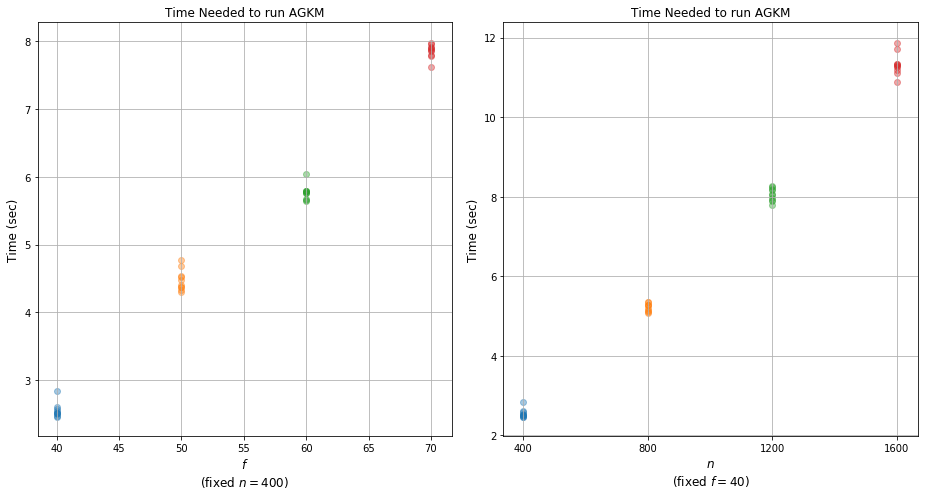

In [20]:
FONTSIZE = 12
FONTWEIGHT = 80
plt.figure(figsize=(13, 7))
plt.subplot(1, 2, 2)
for ind_sh, shapes in enumerate(SHAPE_LIST):
    r, f, n = shapes
    if f==40 :
        plt.scatter(y = timers_ALL_AGKM[ind_sh], x = [str(n) for i in range(NUMBER_OF_RUN)], alpha = 0.4)
plt.xlabel("$n$\n(fixed $f=40$)", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.ylabel("Time (sec)", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.title("Time Needed to run AGKM", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.grid()

plt.subplot(1, 2, 1)
for ind_sh, shapes in enumerate(SHAPE_LIST):
    r, f, n = shapes
    if n==400 :
        plt.scatter(y = timers_ALL_AGKM[ind_sh], x = [f for i in range(NUMBER_OF_RUN)], alpha = 0.4)
plt.xlabel("$f$\n(fixed $n=400$)", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.ylabel("Time (sec)", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.title("Time Needed to run AGKM", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.grid()

plt.tight_layout()
plt.show()

### 1.2.b) HOTTOPIXX 

#### Separable NMF by linear programming

The key observation of this paper is the following:

\begin{align}
\textbf{X} &=  \textbf{F} \, \textbf{W} &&\\ \nonumber
&= \Pi^T \, \Pi \, \textbf{F}  \, \textbf{W}&&\\ \nonumber
&=\Pi^T \left[ {\begin{array}{c} I_r \\ M \\ \end{array} } \right] \textbf{W}&&\\ \nonumber
&= \Pi^T \left[ {\begin{array}{cc} I_r & 0 \\ M & 0 \\ \end{array} } \right] \left[ {\begin{array}{c} I_r \\ M \\ \end{array} } \right] \textbf{W}&&\\ \nonumber
&= \Pi^T \left[ {\begin{array}{cc} I_r & 0 \\ M & 0 \\ \end{array} } \right] \Pi \, \textbf{F} \,  \textbf{W}&&\\ \nonumber
&= \Pi^T \left[ {\begin{array}{cc} I_r & 0 \\ M & 0 \\ \end{array} } \right] \Pi \, \textbf{X} \, =: \textbf{C} \, \textbf{X}
\end{align}

The matrix $\textbf{C}$ is called the factorization localizing. <br/> Any such matrix $\textbf{C}$ is an element of the polyhedral set : 
$$\Phi(\textbf{X}) := \{ \textbf{C} : \: \textbf{C} \geq 0 \: , \textbf{C}\textbf{X} = \textbf{X}, \: Tr(\textbf{C}) = r, \: diag(\textbf{C}) \leq 1, \: \textbf{C}_{ij} \leq \textbf{C}_{jj} \forall i,j \}$$

So to find a factorization of $\textbf{X}$, one can find a feasible element of $\textbf{C} \in \Phi(\textbf{X})$ whose diagonal is integral. And then define $\textbf{W}$ to be the rows of $\textbf{X}$ where $\textbf{C}_{ii} = 1$. After what $\textbf{F}$ consists of the nonzero columns of $\textbf{C}$. Let us explain why briefly.

_**Lemma :** Let $L$ be the set of non $\textit{hott}$ topics (meaning that $|L| = f-r$). Then: $$\forall l \in L, C_{l\,l} = 0, \forall \textbf{C} \in \Phi(\textbf{X})$$_

From this, we can infer that we have, at more, $r$ non zeros columns (because $0 \leq \textbf{C}_{ij} \leq \textbf{C}_{jj} \: \forall i,j $ ). This and the fact that $Tr(\textbf{C}) = r$ and that $diag(\textbf{C}) \leq 1$ gives us that the diagonal of $\textbf{C}$ is made only of zeros and ones.

At this point we want to find the element of $\Phi(\textbf{X})$ with the smallest rank :
\begin{align}
    \textbf{C}^* = {argmin}_{\textbf{C} \in \Phi(\textbf{X})} rg(\textbf{C}) & = argmin_{\textbf{C} \in \Phi(\textbf{X})} diag(\textbf{C} &&\\ 
\end{align}


The problem with this optimization problem is that we might not get a unique solution, which might cause problem for the algorithm to converge, especially in the case of duplicate rows in $\textbf{X}$. So the authors introduce $p \in \mathbb{R}^f$ with distinct positive values and move the problem to : 
\begin{align}
    \min_{\textbf{C} \in \Phi(\textbf{X})} p^Tdiag(\textbf{C})
\end{align}

<img src="Algo2_bittorff.PNG">

#### Robustness to Noise

For the robust case let's define a  small variant of $\Phi(X)$:
$$\Phi_\tau(\textbf{X}) := \{ \textbf{C}: \textbf{C} \geq 0, \: ||\textbf{C}\textbf{X} - \textbf{X}||_{\infty, 1} \leq \tau, \: Tr(\textbf{C}) = r, \: diag(\textbf{C}) \leq 1, \: \textbf{C}_{ij} \leq \textbf{C}_{jj} \forall i,j \}$$
Where :
$$ || \boldsymbol{\Delta} || _{\infty,1} := \max_{1 \leq i \leq f} \sum_{j=1}^n |\Delta_{ij}| $$
The set $\Phi_\tau(\textbf{X})$ consists of matrices that _approximately_ locate a factorization of $\textbf{X}$.


The authors prove the following:<br/>
_ **Theorem :** Suppose that $\epsilon$ and $\alpha$ are positive constants. Suppose $\widehat{\textbf{X}} = \textbf{X} + \boldsymbol{\Delta}$ where $\textbf{X}$  admits a rank-$r$ separable factorization $\textbf{FW}$, such that the rows of $\textbf{W}$ are $\alpha$-robust and $||\boldsymbol{\Delta}||_{\infty,1} \leq \epsilon$. Also assume that for each row $\textbf{X}_{j.}$ that is not hott, we have a margin constraint $||\textbf{X}_{j.} - \textbf{X}_{i.}|| \geq d_0$ for all hott row $i$. <br/>
Then we can find a non negative factorization satisfying  $|| \widehat{\textbf{X}} - \widehat{\textbf{F}} \widehat{\textbf{W}} ||_{\infty,1} \leq 2\epsilon$, provided that $\epsilon \leq \frac{\min\{\alpha d_0, \alpha^2\}}{9(r+1)}$. 
Furthermore this factorization correctly identifies the hott topics appearing in the separable factorization of $\textbf{X}$.
_


And they propose this basic algorithm to solve the problem :
1. Find $\textbf{C} \in \Phi_{2\epsilon}(\textbf{X})$ that minimizes $p^T diag(\textbf{C})$ where $p$ is any vector with distinct positive values
2. Let $I = \{i : \textbf{C}_{ii} = 1\}$ and set $\textbf{W} = \textbf{X}_{I.}$
3. Set $F = argmin_{\textbf{Z} \in \mathbb{R}^{f\,,\,r}} ||\textbf{X} - \textbf{ZW}||_{\infty,1} $

#### Hottopixx- Incremental Gradient Algorithm for NMF

With all of this being said, the authors now focus on an algorithm that might be more efficient than the "naive" approach. Their implementation rely on two optimization techniques : dual decomposition and incremental gradient descent.<br/>
The goal is to minimize $p^Tdiag(\textbf{C})$ subject to $\textbf{C} \in \Phi_\tau(\textbf{X})$. The Lagrangian to this problem is :
$$\mathcal{L}(\textbf{C}, \beta, \textbf{w}) = p^T diag(\textbf{C}) + \beta(Tr(\textbf{C}) - r) + \sum_{i=1}^f w_i (||\textbf{X}_{i.} - [\textbf{C}\textbf{X}]_{i.}||_1 - \tau )$$
With $\beta$ and $\textbf{w} \geq 0$. With still the constraint set : 
$$\Phi_0 := \{ \textbf{C} : \textbf{C} \geq 0 \: ,\: diag(\textbf{C}) \leq 1, \: \textbf{C}_{ij} \leq \textbf{C}_{jj} \forall i,j \}$$
The idea is to alternate between minimizing the Lagrangian over the constraint set $\Phi_0$, and then taking subgradient step with respect to the dual variables : 
$$ w_i \leftarrow w_i + s(||\textbf{X}_{i.} - [\textbf{C}^*\textbf{X}]_{i.}||_1 - \tau) \;\;\;\; , \;\;\;\; 
\beta \leftarrow \beta + s(Tr(\textbf{C}^*) - r)$$

Where $\textbf{C}^*$ is the minimizer of the Lagrangian over $\Phi_0$. In practice, the update on $\textbf{w}$ is not applied, giving that it makes very little difference with respect to the solution quality, according to the authors. <br/>
Note that the Lagrangian can be re-written as : 

$$\mathcal{L}(\textbf{C}, \beta, \textbf{w}) = -\tau \textbf{1}^T\textbf{w} - \beta r + \sum_{k=1}^n \Bigg(\sum_{j \in supp(\textbf{X}_{.k})} w_j ||\textbf{X}_{jk} - [\textbf{C}^*\textbf{X}]_{jk}||_1 + \mu_j (p_j+\beta)C_{jj}\Bigg)$$
With $\mu_j$, the number of non zeros in row $j$ divided by $n$.

<img src="Algo4_bittorff.PNG">



In [21]:
def project_onto_phi0(C):
    '''
    Input :
        C : The factorization localizing matrix
    Output :
        Same shape matrix, but projected onto Phi_0
    '''
    f = int(C.shape[0])
    D = np.sort(C, axis = 0)
    x = np.minimum(1,np.maximum(0,D))
    for col in range(f):
        z = D[:, col]
        z = np.sort(z)
        mu = z[0]
        k_c = 0
        for k in range(1,f):
            if z[k] <= min(1,max(0,mu)):
                k_c = k-1
                break
            else:
                mu = mu*(k)/(k+1) + (1/(k+1))*z[k]
        x[0:k_c+1, col] = min(1,max(0,mu))
    return x


def HOTTOPIXX(X, r, NB_EPOCHS, stepsizes):    
    s_p, s_d = stepsizes
    f, n = X.shape
    
    ## Pick a p
    p = np.random.uniform(low = 0, high=1, size = f)
    
    ## Initialize C and Beta and mu : 
    ## where mu is the number of non-zeros in row j divided by n
    C = np.zeros(shape = (f,f))
    beta = 0
    mu = (np.sum(X!=0, axis =1)/n).reshape(f,1)
    ttqqddmm = tqdm(range(NB_EPOCHS))
    for t in ttqqddmm:
        for i in range(n):
            ## choose k uniformly at random from [n]
            k = np.random.choice(range(n))
            ## C <- C + s_p * sign(X_{.k}-CX_{.k})*X_{.k}^T - s_p*diag(mu ° (beta11 - p))
        
            # sign(X_{.k}-CX_{.k})*X_{.k}^T :
            sign_of_difference = np.sign(X[:,k] - np.dot(C,X[:,k])).reshape(f,1)
            col_k_transposed = (X[:,k].T).reshape(1,f)
            prod_sign_n_col_k_transposed = sign_of_difference * col_k_transposed
            
            # diag(mu ° (beta11 - p)) : 
            beta_minus_p = (beta - p).reshape(1,f)
            diag_prod_mu_bet_minus_p = np.diag(mu*beta_minus_p)
            C = C + s_p * prod_sign_n_col_k_transposed - s_p * diag_prod_mu_bet_minus_p

        ## Project C onto Phi_0:
        C = project_onto_phi0(C)
        ## Update Beta:
        beta = beta + s_d *(np.trace(C) - r)

        ## Log some things
        I = [i for i in range(f) if C[i,i] == 1]
        ttqqddmm.set_description("Indexes where C_ii = 1 " + str(I))

    ## Select W based on diag(C)
    W = X[I,:]
    
    ## Use CVXPY to solve the last LP problem, in order to find F :
    Z_cp = cp.Variable(rows = f, cols = len(I))
    ## The (\infty,1)-norm between X and ZW :
    obj = cp.Minimize(cp.max_entries(cp.sum_entries(cp.atoms.elementwise.abs.abs(X-Z_cp*W), axis = 1))) 
    constraints = [Z_cp >= 0]
    prob = cp.Problem(obj, constraints)
    _ = prob.solve()
    F = np.array(Z_cp.value)
    return F, W, C

In [22]:
r,f,n,d,eta = [5,40,400,0,0]
V,alpha=create_matrix_simulation(r,f,n,d,eta)
F, W, C = HOTTOPIXX(V, r, 50, [1e-1, 1e-2])
print("Distance :", np.linalg.norm(np.dot(F, W)- X))

Indexes where C_ii = 1 [7, 8, 11, 17, 32]: 100%|███████████████████████████████████████| 50/50 [00:01<00:00, 31.07it/s]                                                                                     


Distance : 0.10194321741944026


As we can see, it didn't find the right hott topics, instead it always identifies the hott topics as the highest entry in the vector $p$.

Unfortunatly we didn't get this algorithm to work properly. This is the reason why we implemented all these other algorithms that not only work fine but also perform well.

### 1.2.c) Fast Canonical Hull Algorithms 

Here we present algorithms proposed by A.Kumar in *Fast Conical Hull Algorithms for Near-separable Non-negative
Matrix Factorization (2013)* (https://arxiv.org/pdf/1210.1190.pdf), and one of their extension given in *Near-separable Non-negative Matrix Factorization with ℓ1- and Bregman Loss Functions (2014)* (https://arxiv.org/pdf/1312.7167.pdf)


They introduce their algorithm through geometric intuition. The goal in exact NMF is to find a matrix $W$ such that the cone generated by its columns (ie their non-negative linear combinations) contains all columns of $X$. Under separability assumption the columns of matrix $W$ are to be picked directly form $X$, also know as anchor columns. This algorithm build the cone incrementally by picking a column from $X$ in every iteration. They execute $r$ such iterations for constructing a factorization of inner-dimension $r$. 

An extreme ray $\left\{ tx | t>0 \right\}$ is associated with every anchor point $x$. The points on an extreme ray cannot be expressed as conic combinations of other points in the cone that do not themselves lie on that extreme ray. To identify the next anchor column, the algorithm picks a point outside the current one and projects it to the current cone so that the distance between the point and the projection is minimized in terms of the desired measure of distance. This projection is then used to setup a specific simple criteria which when maximized over the data points, identifies a new anchor. This new anchor is then added to the current set of anchors and the cone is expanded iteratively until all anchors have been picked.

<img src="kumar_illustration.PNG">


#### Kumar & al. 2013

<img src="kumar_xray.PNG">


**Lemma**: The residual matrix $R$, obtained after projection of columns of $X$ onto the current cone satisfies $R^TX_A \leq 0$, where $X_A$ are the extreme rays of the current cone.

**Lemma**: For any point $X_i$ exterior to the current cone, we have $R_i^TX_i >0$, where $R_i$ is the residual of $X_i$ obtained by projecting it onto the current cone.

**Theorem**: The data point $X_{j^\star}$ added at each iteration in the detection step, if the maximizer in equation (1) is unique, is an extreme ray of the current cone that had not been seelcted in previous iterations.

In [23]:
def Kumar2013_optimizer(X,X_a,opti):
     ## Use CVXPY to solve the last LP problem, in order to find F :
    Z_cp = cp.Variable(rows=X_a.shape[1],cols=X.shape[1])
    if opti==1:
        ## The 2-norm between X and X_a*Z:
        obj = cp.Minimize(cp.norm2(X-X_a*Z_cp)) 
        constraints = [Z_cp >= 0]
        prob = cp.Problem(obj, constraints)
        _ = prob.solve()
    else:
        ##  ||X and X_a*Z||_2 ^2
        #tried different things which results in strange results due to computing approximation done by cvxpy 0.4...
        #sensitive to the fact that no sqrt(.) is applied although argmin is equivalent for both problems...
        #and bugged when i specified to put a root_square ...
        obj = cp.Minimize(cp.sum_entries(cp.elementwise.power.power(X-X_a*Z_cp,p=2)))
        constraints = [Z_cp >= 0]
        prob = cp.Problem(obj, constraints)
        _ = prob.solve()
    return np.array(Z_cp.value)

def XRAY_l2(X,r,criterion,opti):
    """
    Inputs: non-negative matrix X (observations/features); 
            inner dimension r;
            criterion: exterior point selection 
    Outputs: non-negative matrices W & H such as X=WH and W=X_A
    """
    m,n=X.shape
    #Initialization
    R=X.copy() #residuals
    A=[] #set of anchor columns
    p=np.random.uniform(low=1,high=1+10**(-5), size=(m,1))
    while len(A)<r:
        #Detection Step- provided 4 criteria (rand,max,dist,greedy) where max criterion outperforms others
        if criterion=="rand":
            residual_columns_norm=[np.linalg.norm(R[:,k],ord=1) for k in range(n)]
            selected_col=np.random.choice(np.nonzero(residual_columns_norm)[0],size=1)
        if criterion=="max": #empirically shown to be the best criterion
            residual_columns_norm=[np.linalg.norm(R[:,k],ord=1) for k in range(n)]
            selected_col=np.argmax(residual_columns_norm)
        #find extreme ray with selected i amoung argmax R_i^T.X_j/p^T.X_j
        fractions= [np.dot(R[:,selected_col].T, X[:,j])/np.dot(p.T, X[:,j]) for j in range(n)]
        anchor_column= np.argmax(fractions) #might be several, but very rarely due to numerical approximation
        #Update of A
        A.append(anchor_column)
        #project onto the current cone
        #there they gave a cyclic coordinate descent, we just used cvxpy optimizers to get free from 2 convergence parameters and get a c++ optimizer
        H=Kumar2013_optimizer(X,X[:,A],opti)
        R=X-np.dot(X[:,A],H)
    return(X[:,A],H, A)

In [24]:
d=0;eta=0
NUMBER_OF_RUN = 10
distances_ALL_XRAY_L2, timers_ALL_XRAY_L2, H_ided_ALL_XRAY_L2= [], [], []
for shapes in SHAPE_LIST : 
    distance_reached, timers, H_identified = [], [], []
    r, f, n=shapes
    print("r=", r, "f=", f, "n=", n, ":")
    ttqq = tqdm(range(NUMBER_OF_RUN))
    for i in ttqq:
        V,alpha=create_matrix_simulation(r,f,n,d,eta)
        start=time.time(); F,W,R=XRAY_l2(V.T,r,"max",opti=1); end=time.time()
        distance_reached.append(np.linalg.norm(V.T-np.dot(F,W),2))
        H_identified.append(R)
        timers.append(end-start)
        ## Display the final distance :
        ttqq.set_description("%.1E" % np.linalg.norm(V.T-np.dot(F,W),2))
    distances_ALL_XRAY_L2.append(distance_reached)
    timers_ALL_XRAY_L2.append(timers)
    H_ided_ALL_XRAY_L2.append(H_identified)

r= 5 f= 40 n= 400 :


1.4E-10: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.23it/s]


r= 5 f= 50 n= 400 :


2.6E-12: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.02it/s]


r= 5 f= 60 n= 400 :


1.0E-11: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


r= 5 f= 70 n= 400 :


2.9E-11: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


r= 5 f= 40 n= 800 :


5.9E-12: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.58s/it]


r= 5 f= 40 n= 1200 :


5.5E-11: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.49s/it]


r= 5 f= 40 n= 1600 :


2.2E-10: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.40s/it]


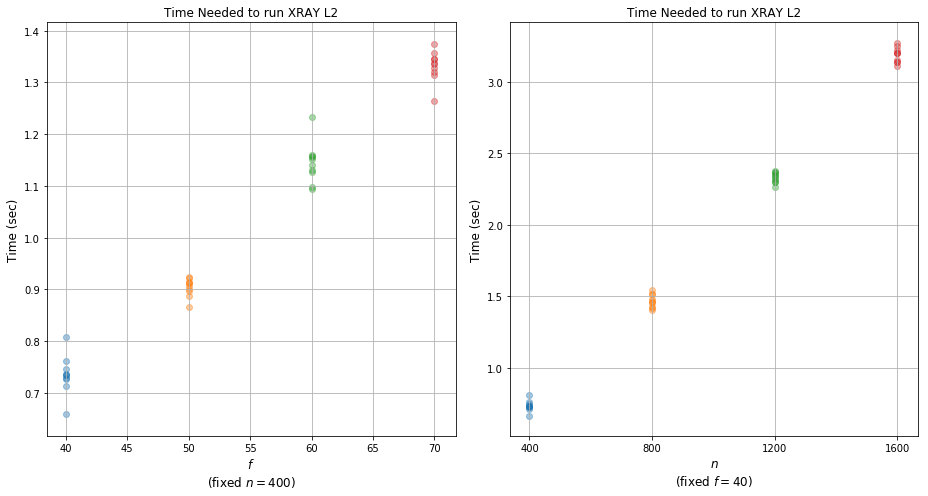

In [25]:
FONTSIZE = 12
FONTWEIGHT = 80
plt.figure(figsize=(13, 7))

plt.subplot(1, 2, 2)
for ind_sh, shapes in enumerate(SHAPE_LIST):
    r, f, n = shapes
    if f==40 :
        plt.scatter(y = timers_ALL_XRAY_L2[ind_sh], x = [str(n) for i in range(NUMBER_OF_RUN)], alpha = 0.4, marker = 'o')
plt.xlabel("$n$\n(fixed $f=40$)", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.ylabel("Time (sec)", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.title("Time Needed to run XRAY L2", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.grid()

plt.subplot(1, 2, 1)
for ind_sh, shapes in enumerate(SHAPE_LIST):
    r, f, n = shapes
    if n==400 :
        plt.scatter(y = timers_ALL_XRAY_L2[ind_sh], x = [f for i in range(NUMBER_OF_RUN)], alpha = 0.4, marker = 'o')
plt.xlabel("$f$\n(fixed $n=400$)", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.ylabel("Time (sec)", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.title("Time Needed to run XRAY L2", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.grid()

plt.tight_layout()
plt.show()

We can already see a difference with AGKM, it seems faster but not as precise though. We will compare them more in details later in this notebook. <br/>
Also we can notice that the time to run XRAY L1 is more volatile than is was with AGKM

#### Kumar & al. 2014

<img src="kumar_robustxray.PNG">

**Lemma**: let $R$ be the residual matrix obtained after $l_1$ projection of columns of $X$ onto the current cone and $D$ be the set of matrices such $D_{ij} = sgn(R_{ij})$ if $R_{ij} \neq 0$ else $D_{ij} \in [-1;1]$. Then, there exists at least one $D^\star \in D$ such that $D^{\star T}X_A \leq 0$, where $X_A$ are anchor columns selected so far.

**Lemma**: For any point $X_i$ exterior to the current cone, there exists at least one $D^\star \in D$ such that it satisfies the previous lemma and $D_i^{\star T}X_i >0$.

**Theorem**: If the maximizer in equation (3) is unique, the data point $X_{j^\star}$ added at each iteration in the selection step, is an anchor that has not been selected in one of the previous iterations.

In [26]:
def Kumar2014_optimizer(X,X_a,opti):
     ## Use CVXPY to solve the last LP problem, in order to find F :
    Z_cp = cp.Variable(rows=X_a.shape[1],cols=X.shape[1])
    
    ## The ||X - X_a*Z||_1:
    if opti==1:
        obj = cp.Minimize(cp.norm1(X-X_a*Z_cp)) 
        constraints = [Z_cp >= 0]
        prob = cp.Problem(obj, constraints)
        _ = prob.solve()
    else:
        obj = cp.Minimize(cp.sum_entries(cp.elementwise.abs.abs(X-X_a*Z_cp))) 
        constraints = [Z_cp >= 0]
        prob = cp.Problem(obj, constraints)
        _ = prob.solve()
    return np.array(Z_cp.value)

def RobustXRAY_l1(X,r,criterion,opti):#near-separable NMF with l1 loss
    f,n=X.shape
    R=X.copy()#residuals
    D_star=X.copy()
    A=[]
    p=np.random.uniform(low=1,high=1+10**(-5),size=(f,1))
    while len(A)<r:
        #Anchor Selection step
        #Two possible criteria:
        if criterion=="rand":
            residual_columns_norm=[np.linalg.norm(R[:,k],ord=1) for k in range(n)]
            selected_col=np.random.choice(np.nonzero(residual_columns_norm)[0],size=1)
        if criterion=="max": #empirically shown to be the best criterion
            residual_columns_norm=[np.linalg.norm(R[:,k],ord=1) for k in range(n)]
            selected_col=np.argmax(residual_columns_norm)
        #choose a suitable Di_star in Di where Dji=sign(Rji) if Rji !=0 else Dji in [-1,1]
        #Here they propose a naive method to set 0 -> -1
        #Or to solve a LP 
        Di_star=np.sign(R[:,selected_col])
        Di_star[Di_star==0]=-1
        fractions= [np.dot(Di_star.T, X[:,j])/np.dot(p.T, X[:,j]) for j in range(n)]
        anchor_column= np.argmax(fractions) #might be several, but very rarely due to numerical approximation
        #Update of A
        A.append(anchor_column)
        #project onto the current cone
        #there they gave a cyclic coordinate descent, we just used cvxpy optimizers to get free from 2 convergence parameters and get a c++ optimizer
        H=Kumar2014_optimizer(X,X[:,A],opti)
        R=X-np.dot(X[:,A],H)
    return X[:,A],H,A

In [27]:
d=0;eta=0
NUMBER_OF_RUN = 10
distances_ALL_XRAY_L1, timers_ALL_XRAY_L1, H_ided_ALL_XRAY_L1= [], [], []
for shapes in SHAPE_LIST : 
    distance_reached, timers, H_identified = [], [], []
    r, f, n=shapes
    print("r=", r, "f=", f, "n=", n, ":")
    ttqq = tqdm(range(NUMBER_OF_RUN))
    for i in ttqq:
        V,alpha=create_matrix_simulation(r,f,n,d,eta)
        start=time.time(); F,W,R=RobustXRAY_l1(V.T,r,"max",opti=1); end=time.time()
        distance_reached.append(np.linalg.norm(V.T-np.dot(F,W),2))
        H_identified.append(R)
        timers.append(end-start)
        ## Display the final distance :
        ttqq.set_description("%.1E" % np.linalg.norm(V.T-np.dot(F,W),2))
    distances_ALL_XRAY_L1.append(distance_reached)
    timers_ALL_XRAY_L1.append(timers)
    H_ided_ALL_XRAY_L1.append(H_identified)

r= 5 f= 40 n= 400 :


4.2E-13: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.80s/it]


r= 5 f= 50 n= 400 :


4.9E-13: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.32s/it]


r= 5 f= 60 n= 400 :


2.3E-14: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.89s/it]


r= 5 f= 70 n= 400 :


1.2E-14: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.31s/it]


r= 5 f= 40 n= 800 :


2.6E-14: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.97s/it]


r= 5 f= 40 n= 1200 :


3.6E-13: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [01:06<00:00,  6.62s/it]


r= 5 f= 40 n= 1600 :


4.5E-14: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [01:32<00:00,  9.23s/it]


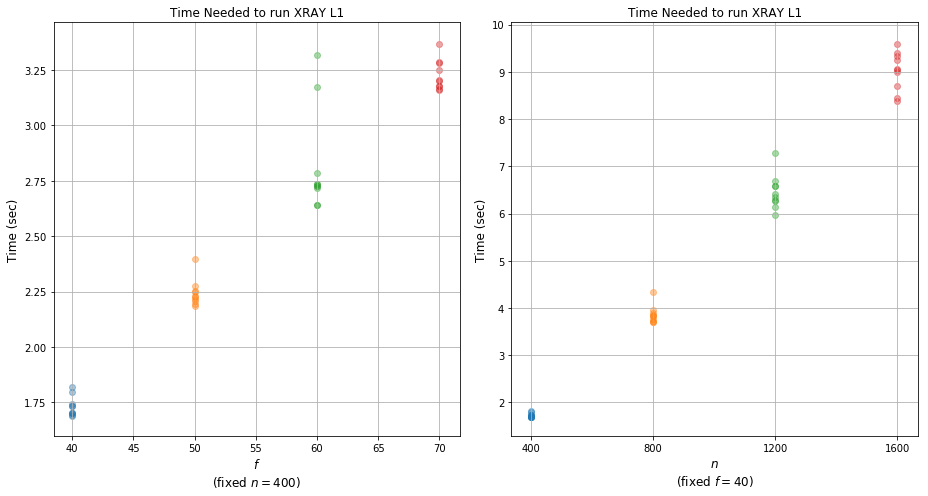

In [28]:
FONTSIZE = 12
FONTWEIGHT = 80
plt.figure(figsize=(13, 7))

plt.subplot(1, 2, 2)
for ind_sh, shapes in enumerate(SHAPE_LIST):
    r, f, n = shapes
    if f==40 :
        plt.scatter(y = timers_ALL_XRAY_L1[ind_sh], x = [str(n) for i in range(NUMBER_OF_RUN)], alpha = 0.4, marker = 'o')
plt.xlabel("$n$\n(fixed $f=40$)", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.ylabel("Time (sec)", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.title("Time Needed to run XRAY L1", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.grid()

plt.subplot(1, 2, 1)
for ind_sh, shapes in enumerate(SHAPE_LIST):
    r, f, n = shapes
    if n==400 :
        plt.scatter(y = timers_ALL_XRAY_L1[ind_sh], x = [f for i in range(NUMBER_OF_RUN)], alpha = 0.4, marker = 'o')
plt.xlabel("$f$\n(fixed $n=400$)", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.ylabel("Time (sec)", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.title("Time Needed to run XRAY L1", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.grid()

plt.tight_layout()
plt.show()

Now let's compare those 3 algorithms together before putting it against the baseline of gradient methods

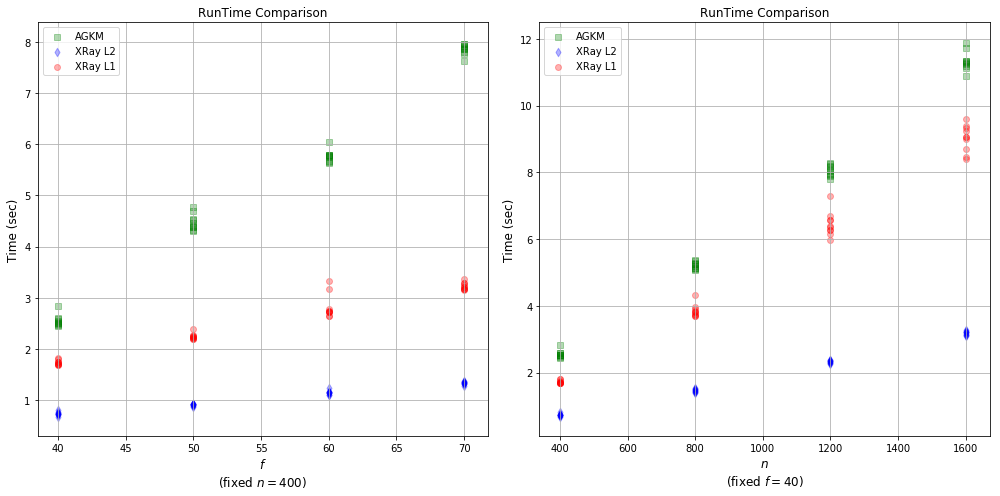

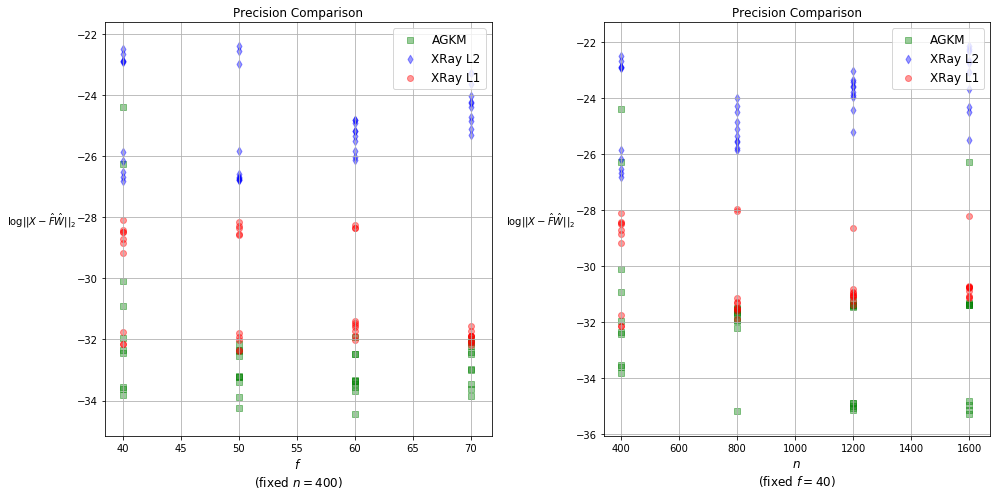

In [29]:
FONTSIZE = 12
FONTWEIGHT = 80
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 2)
for ind_sh, shapes in enumerate(SHAPE_LIST):
    r, f, n = shapes
    if f==40 :
        plt.scatter(y = timers_ALL_AGKM[ind_sh], x = [n for i in range(NUMBER_OF_RUN)], alpha = 0.3, marker = 's',c = "green")
        plt.scatter(y = timers_ALL_XRAY_L2[ind_sh], x = [n for i in range(NUMBER_OF_RUN)], alpha = 0.3, marker = 'd', c = "blue")
        plt.scatter(y = timers_ALL_XRAY_L1[ind_sh], x = [n for i in range(NUMBER_OF_RUN)], alpha = 0.3, marker = 'o',c ="red")
plt.xlabel("$n$\n(fixed $f=40$)", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.ylabel("Time (sec)", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.title("RunTime Comparison", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.grid()
plt.legend(["AGKM", "XRay L2", "XRay L1"])

plt.subplot(1, 2, 1)
for ind_sh, shapes in enumerate(SHAPE_LIST):
    r, f, n = shapes
    if n==400 :
        plt.scatter(y = timers_ALL_AGKM[ind_sh], x = [f for i in range(NUMBER_OF_RUN)], alpha = 0.3, marker = 's',  c = "green")
        plt.scatter(y = timers_ALL_XRAY_L2[ind_sh], x = [f for i in range(NUMBER_OF_RUN)], alpha = 0.3, marker = 'd', c = "blue")
        plt.scatter(y = timers_ALL_XRAY_L1[ind_sh], x = [f for i in range(NUMBER_OF_RUN)], alpha = 0.3, marker = 'o', c ="red")
plt.xlabel("$f$\n(fixed $n=400$)", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.ylabel("Time (sec)", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.title("RunTime Comparison", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.grid()
plt.legend(["AGKM", "XRay L2", "XRay L1"])

plt.tight_layout()
plt.show()


## PRECISION Comparison
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 2)
for ind_sh, shapes in enumerate(SHAPE_LIST):
    r, f, n = shapes
    if f==40 :
        plt.scatter(y = np.log(distances_ALL_AGKM[ind_sh]), x = [n for i in range(NUMBER_OF_RUN)], alpha = 0.4, marker = 's', c = "green")
        plt.scatter(y = np.log(distances_ALL_XRAY_L2[ind_sh]), x = [n for i in range(NUMBER_OF_RUN)], alpha = 0.4, marker = 'd', c = "blue")
        plt.scatter(y = np.log(distances_ALL_XRAY_L1[ind_sh]), x = [n for i in range(NUMBER_OF_RUN)], alpha = 0.4, marker = 'o', c ="red")
plt.xlabel("$n$\n(fixed $f=40$)", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.ylabel("$\log||X- \hat{F}\hat{W}||_{2}$", fontsize = 10, fontweight = FONTWEIGHT,
           rotation = "horizontal", labelpad = 35)
plt.title("Precision Comparison", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.grid()
plt.legend(["AGKM", "XRay L2", "XRay L1"], fontsize = FONTSIZE, loc = 'upper right')

plt.subplot(1, 2, 1)
for ind_sh, shapes in enumerate(SHAPE_LIST):
    r, f, n = shapes
    if n==400 :
        plt.scatter(y = np.log(distances_ALL_AGKM[ind_sh]), x = [f for i in range(NUMBER_OF_RUN)], alpha = 0.4, marker = 's', c = "green")
        plt.scatter(y = np.log(distances_ALL_XRAY_L2[ind_sh]), x = [f for i in range(NUMBER_OF_RUN)], alpha = 0.4, marker = 'd', c = "blue")
        plt.scatter(y = np.log(distances_ALL_XRAY_L1[ind_sh]), x = [f for i in range(NUMBER_OF_RUN)], alpha = 0.4, marker = 'o', c ="red")
plt.xlabel("$f$\n(fixed $n=400$)", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.ylabel("$\log||X- \hat{F}\hat{W}||_{2}$", fontsize = 10, fontweight = FONTWEIGHT,
           rotation = "horizontal", labelpad = 35)
plt.title("Precision Comparison", fontsize = FONTSIZE, fontweight = FONTWEIGHT)
plt.grid()
plt.legend(["AGKM", "XRay L2", "XRay L1"], fontsize = FONTSIZE, loc = 'upper right')
plt.tight_layout()
plt.show()

From this we can conclude that, on the toy example without any noise, AGKM is the slowest but achieve the best accuracy, while XrayL2 is by far the fastest but also the less accurate. Which leaves us with Xray L1 which seems to be a good trade-off between speed and accuracy. <br/>It is also interesting to note that the size of the input don't seem to impact significantly the accuracy of each of these methods.

# II. Simulations and applications


So far, we have described the different algorithm we studied for this project. We looked at a toy example where the input was separable. <br/> Now let's look at some more toy examples and an implementation on a real life dataset

Let's just recap briefly what has been showed so far. <br/>

Here AGKM is really efficient to compute NMF but required knowledge of $\alpha$ and an $\epsilon$ bounded by a function of $\alpha$. 

- if we consider a fictive $\epsilon$ inferior to the minimal distance between rows( empirically satisfying because of randomness if we don't add duplicates, but not theorically). For all $k$, $N_k$ is composed of all remaining features, therefore distances to convexhull are theorically zero for non hott-topics (order of computing errors = $10^{-11}$) and much larger for hott-topics. 

**comparison with Fast Canonical Hull algorithms**

- All of them can specify which features are hott-topics
- AGKM optimizer for $||.||_{\infty,1}$ which directly optimize "l1-norm" from numpy, seems to be more efficient than Kumar algorithms which approximates $X$ through $||.||_2$ and $||.||_1$

**Analysis**

- AGKM algorithm and Kumar's algorithms are able to detect hott topics. Reconstruction according to Frobenius norm seems more precise while optimizing for $||.||_{\infty, 1}$. 
- Except Lee Seung algorithm which converge very slowly and therefore requires a lot of testing time to verify if it can reach set goal. We found logic results in view of our theorical developments (sensitivity to initialization // improvements of convergence speed )

## II.1) simulations on toy dataset


Here we aim to compare:

- Accuracy provided by AGKM and Kumar algorithms, which means how precise NMF is according to $||.||_2$ and if they can find Hott_topics.
- For a given precision (minimum precision of previous algorithms), we compare time amoung two-block descent algorithms to achieve it. In fact,most of the time we can push further the optimization to get slightly better precisions. For these algorithms, convergence speed is also influenced by initialization (We just used random initialization, most promising recent researches proned use of SVD).
- As a reminder: Note that the original cost function of NMF is non-convex, and non-convex optimization algorithms in this regard only guarantee stationarity of limit points, as is the case with multiplicative updates. In other words, the algorithm can be converging to local minima, rather than the global minimum. So implementing a while loop with a target with Lee Seung algorithm could not terminate. Which is more unlikely with $\delta$ adjustments proposed by Gillis and Glineur, which can help to escape from local minima above the set goal.



###  II.1.a) Variations of noise intensity

On these test, we use the minimal distance we got from AGKM, Xray_L2 and Xray_L1 as a goal for the descent methods. We also put a maximum runtime of 10secs on the gradient methods, the reason for this value is that if it takes more than 10secs to get to the designated goal then the trade-off time-accuracy isn't really worth it.

In [30]:
import re

In [31]:
ALGOS  = ["AGKM", "XRay_L2", "XRay_L1", "LS_MU",
          "GG_MU", "GG_HALS", "GG_MU_Hy", "GG_HALS_hy"]

In [32]:
max_time = 10
NUMBER_OF_RUN = 5
etas = [0.1, 0.5, 1, 1.5, 2, 4, 5, 7, 9, 10] ## etas we are going to run tests on

ALGOS  = ["AGKM", "XRay_L2", "XRay_L1", "LS_MU",
          "GG_MU", "GG_HALS", "GG_MU_Hy", "GG_HALS_hy"]
Distance_df = pd.DataFrame(index = ALGOS,
                           columns=[["run_"+str(eta)+"_"+str(i) for i in range(NUMBER_OF_RUN) for eta in etas]])
Timers_df = pd.DataFrame(index = ALGOS,
                         columns=[["run_"+str(eta)+"_"+str(i) for i in range(NUMBER_OF_RUN) for eta in etas]])
Fails_df = pd.DataFrame(np.zeros((len(ALGOS),len(etas))) ,index = ALGOS,
                         columns=[["run_"+str(eta) for eta in etas]])
r, f, n = [5, 40, 400]
d = 0

print("r=", r, "f=", f, "n=", n, ":")
for eta in etas :
    print("eta =", eta, ":")
    ttqq = tqdm(range(NUMBER_OF_RUN))
    ## For each eta we run the NMF NUMBER_OF_RUN times
    ## For each of those run, we get the distance and the time needed to get there
    ## We use the minimal distance we got from AGKM, Xray_L2 and Xray_L1 as a goal for the descent methods
    AGKM_Fails = 0
    for i in ttqq:
        V,alpha=create_matrix_simulation(r,f,n,d,eta)
        
        ## AGKM
        try : 
            epsilon=alpha**2/(20+13*alpha); t0 = time.time(); F,W,R=AGKM(V,alpha,epsilon); t1 = time.time()
            Distance_df.loc['AGKM', "run_"+str(eta)+"_"+str(i)] = np.linalg.norm(V-np.dot(F,W),2)
            Timers_df.loc['AGKM', "run_"+str(eta)+"_"+str(i)] = t1-t0
            ttqq.set_description("%.1E" % Distance_df.loc['AGKM', "run_"+str(eta)+"_"+str(i)])
        except : 
            ttqq.set_description("Failed"); Fails_df.loc['AGKM', "run_"+str(eta)] +=1
            
        ## XRay L2
        try : 
            t0 = time.time(); F,W,R=XRAY_l2(V.T,r,"max",opti=1); t1 = time.time()
            Distance_df.loc['XRay_L2', "run_"+str(eta)+"_"+str(i)] = np.linalg.norm(V.T-np.dot(F,W),2)
            Timers_df.loc['XRay_L2', "run_"+str(eta)+"_"+str(i)] = t1-t0
            ttqq.set_description("%.1E" % Distance_df.loc['XRay_L2', "run_"+str(eta)+"_"+str(i)])
        except : 
            ttqq.set_description("Failed"); Fails_df.loc['XRay_L2', "run_"+str(eta)] +=1
            
        ## XRay L1
        try : 
            t0 = time.time(); F,W,R=RobustXRAY_l1(V.T,r,"max",opti=1); t1 = time.time()
            Distance_df.loc['XRay_L1', "run_"+str(eta)+"_"+str(i)] = np.linalg.norm(V.T-np.dot(F,W),2)
            Timers_df.loc['XRay_L1', "run_"+str(eta)+"_"+str(i)] = t1-t0
            ttqq.set_description("%.1E" % Distance_df.loc['XRay_L1', "run_"+str(eta)+"_"+str(i)])
        except : 
            ttqq.set_description("Failed"); Fails_df.loc['XRay_L1', "run_"+str(eta)] +=1
        
        if (np.isnan(np.min(Distance_df.loc[['AGKM', 'XRay_L2', 'XRay_L1'], "run_"+str(eta)+"_"+str(i)])[0])):
            min_dist_reached = 10**(-10)
        else :
            min_dist_reached = np.min(Distance_df.loc[['AGKM', 'XRay_L2', 'XRay_L1'], "run_"+str(eta)+"_"+str(i)])[0]

        F_init = np.random.uniform(low=10**(-16), high= 1, size=(f,r))
        W_init = np.random.uniform(low=10**(-16), high= 1, size=(r,n))
        
        ## LeeSeung_MU
        try : 
            t0 = time.time(); distances, F, W= LeeSeung_MU(V, r, F_init, W_init, steps=max_time, goal=min_dist_reached); t1 = time.time()
            Distance_df.loc['LS_MU', "run_"+str(eta)+"_"+str(i)] = np.linalg.norm(V-np.dot(F,W),2)
            Timers_df.loc['LS_MU', "run_"+str(eta)+"_"+str(i)] = t1-t0
            ttqq.set_description("%.1E" % Distance_df.loc['LS_MU', "run_"+str(eta)+"_"+str(i)])
        except : 
            ttqq.set_description("Failed"); Fails_df.loc['LS_MU', "run_"+str(eta)] +=1
        
        ## GillisGlineur_MU
        try : 
            t0 = time.time(); distances, F, W= GillisGlineur_MU(V, r, F_init, W_init, 10**(-16), steps=max_time, goal=min_dist_reached); t1 = time.time()
            Distance_df.loc['GG_MU', "run_"+str(eta)+"_"+str(i)] = np.linalg.norm(V-np.dot(F,W),2)
            Timers_df.loc['GG_MU', "run_"+str(eta)+"_"+str(i)] = t1-t0
            ttqq.set_description("%.1E" % Distance_df.loc['GG_MU', "run_"+str(eta)+"_"+str(i)])
        except : 
            ttqq.set_description("Failed"); Fails_df.loc['GG_MU', "run_"+str(eta)] +=1
        
        ## GillisGlineur_HALS
        try : 
            t0 = time.time(); distances, F, W= GillisGlineur_HALS(V, r, F_init, W_init, 10**(-16), steps=max_time, goal=min_dist_reached); t1 = time.time()
            Distance_df.loc['GG_HALS', "run_"+str(eta)+"_"+str(i)] = np.linalg.norm(V-np.dot(F,W),2)
            Timers_df.loc['GG_HALS', "run_"+str(eta)+"_"+str(i)] = t1-t0
            ttqq.set_description("%.1E" % Distance_df.loc['GG_HALS', "run_"+str(eta)+"_"+str(i)])
        except : 
            ttqq.set_description("Failed"); Fails_df.loc['GG_HALS', "run_"+str(eta)] +=1
        
        ## GillisGlineur_MU_hybrid
        try : 
            t0 = time.time(); distances, F, W= GillisGlineur_MU_hybrid(V, r, F_init, W_init, 10**(-16), steps=max_time, alpha=1, epsilon=0.1, goal=min_dist_reached); t1 = time.time()
            Distance_df.loc['GG_MU_Hy', "run_"+str(eta)+"_"+str(i)] = np.linalg.norm(V-np.dot(F,W),2)
            Timers_df.loc['GG_MU_Hy', "run_"+str(eta)+"_"+str(i)] = t1-t0
            ttqq.set_description("%.1E" % Distance_df.loc['GG_MU_Hy', "run_"+str(eta)+"_"+str(i)])
        except : 
            ttqq.set_description("Failed"); Fails_df.loc['GG_MU_Hy', "run_"+str(eta)] +=1
        
        ## GillisGlineur_HALS_hybrid
        try : 
            t0 = time.time(); distances, F, W= GillisGlineur_HALS_hybrid(V, r, F_init, W_init, 10**(-16), steps=max_time, alpha=0.5, epsilon=0.1, goal=min_dist_reached); t1 = time.time()
            Distance_df.loc['GG_HALS_hy', "run_"+str(eta)+"_"+str(i)] = np.linalg.norm(V-np.dot(F,W),2)
            Timers_df.loc['GG_HALS_hy', "run_"+str(eta)+"_"+str(i)] = t1-t0
            ttqq.set_description("%.1E" % Distance_df.loc['GG_HALS_hy', "run_"+str(eta)+"_"+str(i)])
        except : 
            ttqq.set_description("Failed"); Fails_df.loc['GG_HALS_hy', "run_"+str(eta)] +=1
    

r= 5 f= 40 n= 400 :
eta = 0.1 :


8.2E-06: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [03:17<00:00, 39.53s/it]


eta = 0.5 :


4.4E-05: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [03:07<00:00, 37.50s/it]


eta = 1 :


8.5E-05: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [03:07<00:00, 37.57s/it]


eta = 1.5 :


1.4E-04: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [03:03<00:00, 36.79s/it]


eta = 2 :


1.8E-04: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [03:03<00:00, 36.66s/it]


eta = 4 :


3.4E-04: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [03:02<00:00, 36.57s/it]


eta = 5 :


4.0E-04: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [03:02<00:00, 36.52s/it]


eta = 7 :


5.4E-04: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [03:03<00:00, 36.67s/it]


eta = 9 :


8.3E-04: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [03:15<00:00, 39.14s/it]


eta = 10 :


7.8E-04: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [03:18<00:00, 39.60s/it]


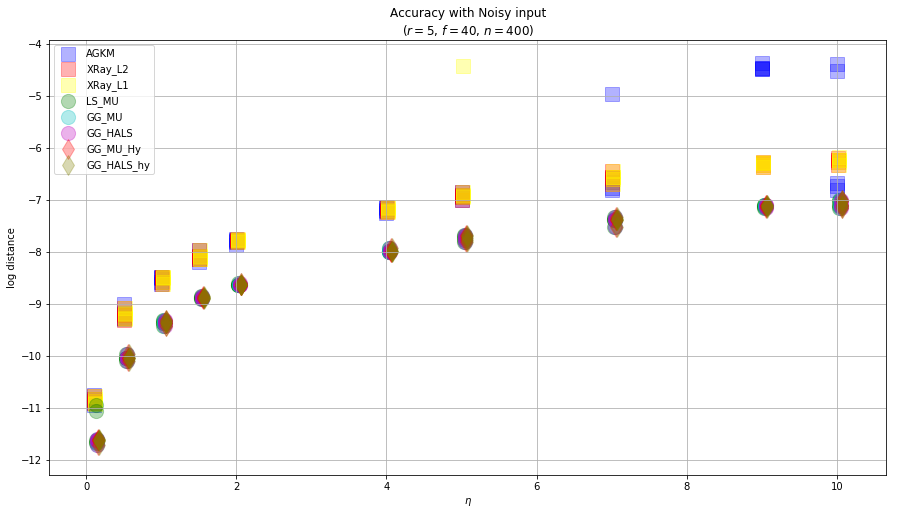

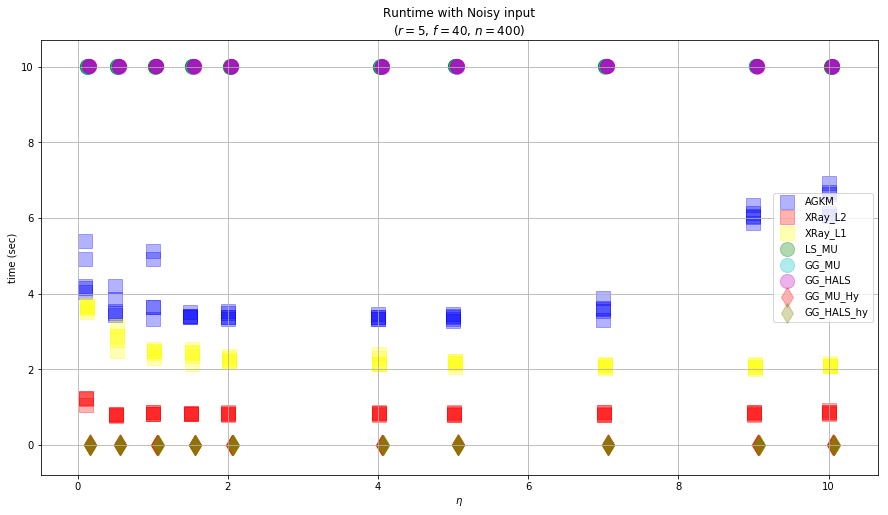

In [33]:
import matplotlib

ALGOS_COL = {"AGKM" : "blue", "XRay_L2" : "red", "XRay_L1" : "yellow",
             "LS_MU": "green", "GG_MU": "c", "GG_HALS" : "m", "GG_MU_Hy": "red", "GG_HALS_hy": "olive"}

plt.figure(figsize=(15,8))
for ind_algo, algo in enumerate(ALGOS):
    if algo in ["AGKM", "XRay_L2", "XRay_L1"]:
        mark_style = matplotlib.markers.MarkerStyle(marker='s', fillstyle='full')
    elif algo in ["GG_MU_Hy", "GG_HALS_hy"]:
        mark_style = matplotlib.markers.MarkerStyle(marker='d', fillstyle='full')
    else :
        mark_style = matplotlib.markers.MarkerStyle(marker='o', fillstyle='full')
    plt.scatter(x = [float(re.search('_(.*)_', indd).group(1)) + ind_algo*1e-2 for indd in Distance_df.loc[algo].index.levels[0] if not np.isnan(Distance_df.loc[algo, indd][0]) ],
                y = [np.log(Distance_df.loc[algo, indd][0]) for indd in Distance_df.loc[algo].index.levels[0] if not np.isnan(Distance_df.loc[algo, indd][0])],
                alpha = 0.3, label = algo, marker = mark_style, s =200, c = ALGOS_COL[algo])
plt.xlabel("$\eta$")
plt.ylabel("log distance")
plt.title("Accuracy with Noisy input\n($r = %.d$, $f = %.d$, $n = %.d$)"%(5, 40, 400))
plt.legend(ALGOS)
plt.grid()
plt.show()

plt.figure(figsize=(15,8))
for ind_algo, algo in enumerate(ALGOS):
    if algo in ["AGKM", "XRay_L2", "XRay_L1"]:
        mark_style = matplotlib.markers.MarkerStyle(marker='s', fillstyle='full')
    elif algo in ["GG_MU_Hy", "GG_HALS_hy"]:
        mark_style = matplotlib.markers.MarkerStyle(marker='d', fillstyle='full')
    else :
        mark_style = matplotlib.markers.MarkerStyle(marker='o', fillstyle='full')
    plt.scatter(x = [float(re.search('_(.*)_', indd).group(1)) + ind_algo*1e-2 for indd in Timers_df.loc[algo].index.levels[0] if not np.isnan(Timers_df.loc[algo, indd][0]) ],
                y = [Timers_df.loc[algo, indd][0] for indd in Timers_df.loc[algo].index.levels[0] if not np.isnan(Timers_df.loc[algo, indd][0])],
                alpha = 0.3, label = algo, marker = mark_style, s =200, c = ALGOS_COL[algo])
plt.xlabel("$\eta$")
plt.ylabel("time (sec)")
plt.title("Runtime with Noisy input\n($r = %.d$, $f = %.d$, $n = %.d$)"%(5, 40, 400))
plt.legend(ALGOS)
plt.grid()
plt.show()

In [34]:
Distance_noisy_df = Distance_df
Timers_noisy_df = Timers_df

**Analysis**

- for $\eta \leq 1$, AGKM is able to identify hott pics and above this threshold, algorithm results in undivided clusters and then can't terminate. Kumar's algorithms both seem a lot more robust.
- Two-Block descent gradient algorithms can result in better precision.

###  II.1.b) Variations of noise intensity - with duplicates

In [35]:
max_time = 10
NUMBER_OF_RUN = 5
ds = [0, 1, 2, 3, 4, 5] ## d we are going to run tests on

ALGOS  = ["AGKM", "XRay_L2", "XRay_L1", "LS_MU",
          "GG_MU", "GG_HALS", "GG_MU_Hy", "GG_HALS_hy"]
Distance_df = pd.DataFrame(index = ALGOS,
                           columns=[["run_"+str(d)+"_"+str(i) for i in range(NUMBER_OF_RUN) for d in ds]])
Timers_df = pd.DataFrame(index = ALGOS,
                         columns=[["run_"+str(d)+"_"+str(i) for i in range(NUMBER_OF_RUN) for d in ds]])
Fails_df = pd.DataFrame(np.zeros((len(ALGOS),len(ds))) ,index = ALGOS,
                         columns=[["run_"+str(d) for d in ds]])
r, f, n = [5, 40, 400]
eta = 1.

print("r=", r, "f=", f, "n=", n,"eta=", eta,":")
for d in ds :
    print("d =", d, ":")
    ttqq = tqdm(range(NUMBER_OF_RUN))
    ## For each eta we run the NMF NUMBER_OF_RUN times
    ## For each of those run, we get the distance and the time needed to get there
    ## We use the minimal distance we got from AGKM, Xray_L2 and Xray_L1 as a goal for the descent methods
    AGKM_Fails = 0
    for i in ttqq:
        V,alpha=create_matrix_simulation(r,f,n,d,eta)
        
        ## AGKM
        try : 
            epsilon=alpha**2/(20+13*alpha); t0 = time.time(); F,W,R=AGKM(V,alpha,epsilon); t1 = time.time()
            Distance_df.loc['AGKM', "run_"+str(d)+"_"+str(i)] = np.linalg.norm(V-np.dot(F,W),2)
            Timers_df.loc['AGKM', "run_"+str(d)+"_"+str(i)] = t1-t0
            ttqq.set_description("%.1E" % Distance_df.loc['AGKM', "run_"+str(d)+"_"+str(i)])
        except : 
            ttqq.set_description("Failed"); Fails_df.loc['AGKM', "run_"+str(d)] +=1
            
        ## XRay L2
        try : 
            t0 = time.time(); F,W,R=XRAY_l2(V.T,r,"max",opti=1); t1 = time.time()
            Distance_df.loc['XRay_L2', "run_"+str(d)+"_"+str(i)] = np.linalg.norm(V.T-np.dot(F,W),2)
            Timers_df.loc['XRay_L2', "run_"+str(d)+"_"+str(i)] = t1-t0
            ttqq.set_description("%.1E" % Distance_df.loc['XRay_L2', "run_"+str(d)+"_"+str(i)])
        except : 
            ttqq.set_description("Failed"); Fails_df.loc['XRay_L2', "run_"+str(d)] +=1
            
        ## XRay L1
        try : 
            t0 = time.time(); F,W,R=RobustXRAY_l1(V.T,r,"max",opti=1); t1 = time.time()
            Distance_df.loc['XRay_L1', "run_"+str(d)+"_"+str(i)] = np.linalg.norm(V.T-np.dot(F,W),2)
            Timers_df.loc['XRay_L1', "run_"+str(d)+"_"+str(i)] = t1-t0
            ttqq.set_description("%.1E" % Distance_df.loc['XRay_L1', "run_"+str(d)+"_"+str(i)])
        except : 
            ttqq.set_description("Failed"); Fails_df.loc['XRay_L1', "run_"+str(d)] +=1
        
        if (np.isnan(np.min(Distance_df.loc[['AGKM', 'XRay_L2', 'XRay_L1'], "run_"+str(d)+"_"+str(i)])[0])):
            min_dist_reached = 10**(-10)
        else :
            min_dist_reached = np.min(Distance_df.loc[['AGKM', 'XRay_L2', 'XRay_L1'], "run_"+str(d)+"_"+str(i)])[0]

        F_init = np.random.uniform(low=10**(-16), high= 1, size=(f,r))
        W_init = np.random.uniform(low=10**(-16), high= 1, size=(r,n))
        
        ## LeeSeung_MU
        try : 
            t0 = time.time(); distances, F, W= LeeSeung_MU(V, r, F_init, W_init, steps=max_time, goal=min_dist_reached); t1 = time.time()
            Distance_df.loc['LS_MU', "run_"+str(d)+"_"+str(i)] = np.linalg.norm(V-np.dot(F,W),2)
            Timers_df.loc['LS_MU', "run_"+str(d)+"_"+str(i)] = t1-t0
            ttqq.set_description("%.1E" % Distance_df.loc['LS_MU', "run_"+str(d)+"_"+str(i)])
        except : 
            ttqq.set_description("Failed"); Fails_df.loc['LS_MU', "run_"+str(d)] +=1
        
        ## GillisGlineur_MU
        try : 
            t0 = time.time(); distances, F, W= GillisGlineur_MU(V, r, F_init, W_init, 10**(-16), steps=max_time, goal=min_dist_reached); t1 = time.time()
            Distance_df.loc['GG_MU', "run_"+str(d)+"_"+str(i)] = np.linalg.norm(V-np.dot(F,W),2)
            Timers_df.loc['GG_MU', "run_"+str(d)+"_"+str(i)] = t1-t0
            ttqq.set_description("%.1E" % Distance_df.loc['GG_MU', "run_"+str(d)+"_"+str(i)])
        except : 
            ttqq.set_description("Failed"); Fails_df.loc['GG_MU', "run_"+str(d)] +=1
        
        ## GillisGlineur_HALS
        try : 
            t0 = time.time(); distances, F, W= GillisGlineur_HALS(V, r, F_init, W_init, 10**(-16), steps=max_time, goal=min_dist_reached); t1 = time.time()
            Distance_df.loc['GG_HALS', "run_"+str(d)+"_"+str(i)] = np.linalg.norm(V-np.dot(F,W),2)
            Timers_df.loc['GG_HALS', "run_"+str(d)+"_"+str(i)] = t1-t0
            ttqq.set_description("%.1E" % Distance_df.loc['GG_HALS', "run_"+str(d)+"_"+str(i)])
        except : 
            ttqq.set_description("Failed"); Fails_df.loc['GG_HALS', "run_"+str(d)] +=1
        
        ## GillisGlineur_MU_hybrid
        try : 
            t0 = time.time(); distances, F, W= GillisGlineur_MU_hybrid(V, r, F_init, W_init, 10**(-16), steps=max_time, alpha=1, epsilon=0.1, goal=min_dist_reached); t1 = time.time()
            Distance_df.loc['GG_MU_Hy', "run_"+str(d)+"_"+str(i)] = np.linalg.norm(V-np.dot(F,W),2)
            Timers_df.loc['GG_MU_Hy', "run_"+str(d)+"_"+str(i)] = t1-t0
            ttqq.set_description("%.1E" % Distance_df.loc['GG_MU_Hy', "run_"+str(d)+"_"+str(i)])
        except : 
            ttqq.set_description("Failed"); Fails_df.loc['GG_MU_Hy', "run_"+str(d)] +=1
        
        ## GillisGlineur_HALS_hybrid
        try : 
            t0 = time.time(); distances, F, W= GillisGlineur_HALS_hybrid(V, r, F_init, W_init, 10**(-16), steps=max_time, alpha=0.5, epsilon=0.1, goal=min_dist_reached); t1 = time.time()
            Distance_df.loc['GG_HALS_hy', "run_"+str(d)+"_"+str(i)] = np.linalg.norm(V-np.dot(F,W),2)
            Timers_df.loc['GG_HALS_hy', "run_"+str(d)+"_"+str(i)] = t1-t0
            ttqq.set_description("%.1E" % Distance_df.loc['GG_HALS_hy', "run_"+str(d)+"_"+str(i)])
        except : 
            ttqq.set_description("Failed"); Fails_df.loc['GG_HALS_hy', "run_"+str(d)] +=1
    

r= 5 f= 40 n= 400 eta= 1.0 :
d = 0 :


9.0E-05: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [03:04<00:00, 36.93s/it]


d = 1 :


9.0E-05: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [03:10<00:00, 38.01s/it]


d = 2 :


9.1E-05: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [03:09<00:00, 37.85s/it]


d = 3 :


8.5E-05: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [03:13<00:00, 38.73s/it]


d = 4 :


8.5E-05: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [03:16<00:00, 39.35s/it]


d = 5 :


8.5E-05: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [03:18<00:00, 39.74s/it]


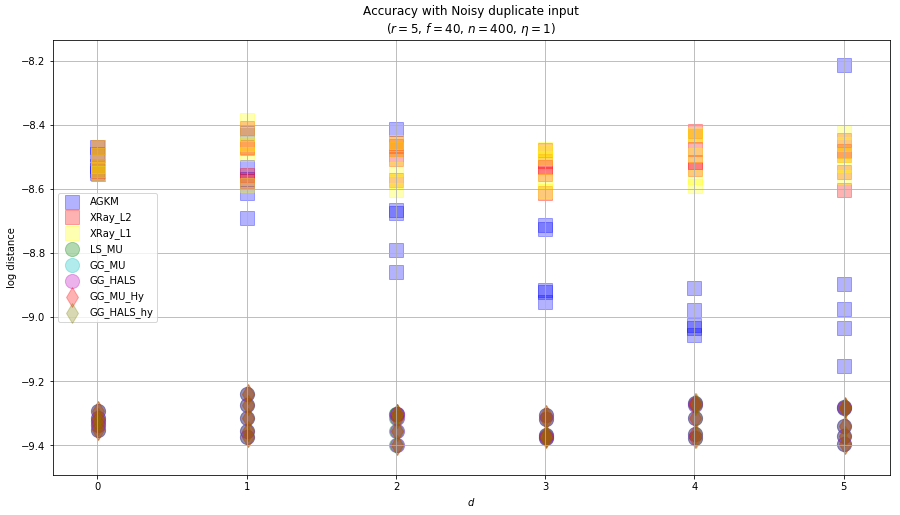

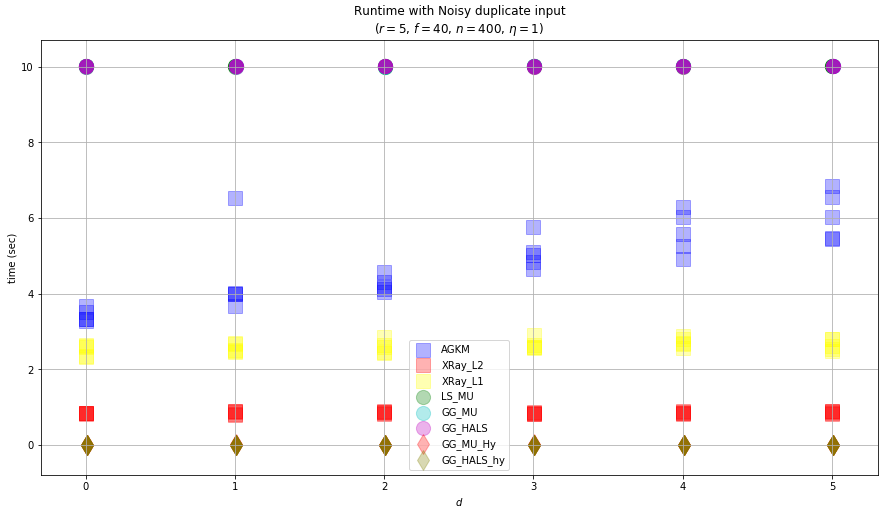

In [36]:
import matplotlib

ALGOS_COL = {"AGKM" : "blue", "XRay_L2" : "red", "XRay_L1" : "yellow",
             "LS_MU": "green", "GG_MU": "c", "GG_HALS" : "m", "GG_MU_Hy": "red", "GG_HALS_hy": "olive"}

plt.figure(figsize=(15,8))
for ind_algo, algo in enumerate(ALGOS):
    if algo in ["AGKM", "XRay_L2", "XRay_L1"]:
        mark_style = matplotlib.markers.MarkerStyle(marker='s', fillstyle='full')
    elif algo in ["GG_MU_Hy", "GG_HALS_hy"]:
        mark_style = matplotlib.markers.MarkerStyle(marker='d', fillstyle='full')
    else :
        mark_style = matplotlib.markers.MarkerStyle(marker='o', fillstyle='full')
    plt.scatter(x = [float(re.search('_(.*)_', indd).group(1)) + ind_algo*1e-3 for indd in Distance_df.loc[algo].index.levels[0] if not np.isnan(Distance_df.loc[algo, indd][0]) ],
                y = [np.log(Distance_df.loc[algo, indd][0]) for indd in Distance_df.loc[algo].index.levels[0] if not np.isnan(Distance_df.loc[algo, indd][0])],
                alpha = 0.3, label = algo, marker = mark_style, s =200, c = ALGOS_COL[algo])
plt.xlabel("$d$")
plt.ylabel("log distance")
plt.title("Accuracy with Noisy duplicate input\n($r = %.d$, $f = %.d$, $n = %.d$, $\eta = %.d$)"%(5, 40, 400, 1))
plt.legend(ALGOS)
plt.grid()
plt.show()

plt.figure(figsize=(15,8))
for ind_algo, algo in enumerate(ALGOS):
    if algo in ["AGKM", "XRay_L2", "XRay_L1"]:
        mark_style = matplotlib.markers.MarkerStyle(marker='s', fillstyle='full')
    elif algo in ["GG_MU_Hy", "GG_HALS_hy"]:
        mark_style = matplotlib.markers.MarkerStyle(marker='d', fillstyle='full')
    else :
        mark_style = matplotlib.markers.MarkerStyle(marker='o', fillstyle='full')
    plt.scatter(x = [float(re.search('_(.*)_', indd).group(1)) + ind_algo*1e-3 for indd in Timers_df.loc[algo].index.levels[0] if not np.isnan(Timers_df.loc[algo, indd][0]) ],
                y = [Timers_df.loc[algo, indd][0] for indd in Timers_df.loc[algo].index.levels[0] if not np.isnan(Timers_df.loc[algo, indd][0])],
                alpha = 0.3, label = algo, marker = mark_style, s =200, c = ALGOS_COL[algo])
plt.xlabel("$d$")
plt.ylabel("time (sec)")
plt.title("Runtime with Noisy duplicate input\n($r = %.d$, $f = %.d$, $n = %.d$, $\eta = %.d$)"%(5, 40, 400, 1))
plt.legend(ALGOS)
plt.grid()
plt.show()

After all these tests on various algorithms, we have come to the conclusion that HALS with hybrid criterion proposed by Gillis and Glineur and RobustXRAY proposed by Kumar are the two best candidate to solve NMF.<br/>
After that it is up to the practitioner to choose which of these 2 is better suited to his particular problem. HALS is very fast while still being very accurate, but RobustXRAY has the advantage to being easier to interpret.

## II.2) Application to a real dataset

Here we will test the best candidates on real life data.

### II.2.a) Regression

In [37]:
"""Real dataset: here we investigate our NMF algorithms on "communities and crime" dataset
http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime
Regression target : ViolentCrimesPerPop: total number of violent crimes per 100K popuation (numeric - decimal)/Last variable

NB: Features are already normalized
"""
df=pd.read_csv('crimes',sep=",", encoding='utf-8',header=None)
df=df.applymap(lambda x: np.nan if x=='?' else x)
#simple pre-processing for missing values
columns_to_delete=[]
columns_to_fill=[]
for col in df.columns:
    n=len(df)
    per_NAN= df.iloc[:,col].isnull().sum()/n
    if per_NAN>0.1:
        columns_to_delete.append(col)
    elif per_NAN>0:
        columns_to_fill.append(col)
df.drop(labels=columns_to_delete+[0,3,4],axis=1,inplace=True)#plus: five first features which aren't predictive ones 
#state: US state (by number) - not counted as predictive above, but if considered, should be consided nominal (nominal) 
#-- county: numeric code for county - not predictive, and many missing values (numeric) 
#-- community: numeric code for community - not predictive and many missing values (numeric) 
#-- communityname: community name - not predictive - for information only (string) 
#-- fold: fold number for non-random 10 fold cross validation, potentially useful for debugging, paired tests - not predictive (numeric) 
df=df.applymap(lambda x: float(x))
df=df.fillna(df.mean()); df.columns=range(df.shape[1])
print(df.info())
df.head() ## finally we have 100 features with 1994 observations and one target



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 101 entries, 0 to 100
dtypes: float64(101)
memory usage: 1.5 MB
None


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


First of all for a simple model, we investigate how well regression perform with several quantities of observations, in order to reduce time of our experiments with NMF algorithms.

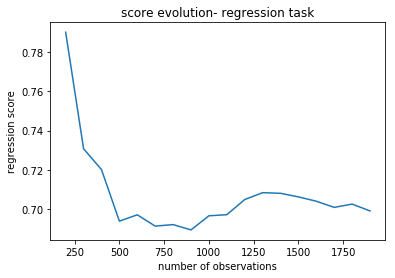

In [38]:
###First let's train a simple model with all features 
from sklearn.linear_model import LinearRegression
scores=[]
list_no_obs=range(200,len(df),100)
for no_obs in list_no_obs:
    y=np.array(df.iloc[:no_obs,-1])
    X=np.array(df.iloc[:no_obs,:-1])
    reg = LinearRegression().fit(X, y)
    scores.append( reg.score(X, y))
plt.plot(list_no_obs,scores)
plt.title('score evolution- regression task')
plt.xlabel('number of observations')
plt.ylabel('regression score')
plt.show()



For different quantities of observations; we analyse how features selection given by RobustXRAY_l1 and features coming from dimension reduction of GillisGlineur_HALS_hybrid perform with our regression task.

In [39]:
from tqdm import tqdm

(200, 100)


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [39:28<00:00, 98.68s/it]


(400, 100)


100%|███████████████████████████████████████████████████████████████████████████████| 24/24 [1:27:26<00:00, 218.62s/it]


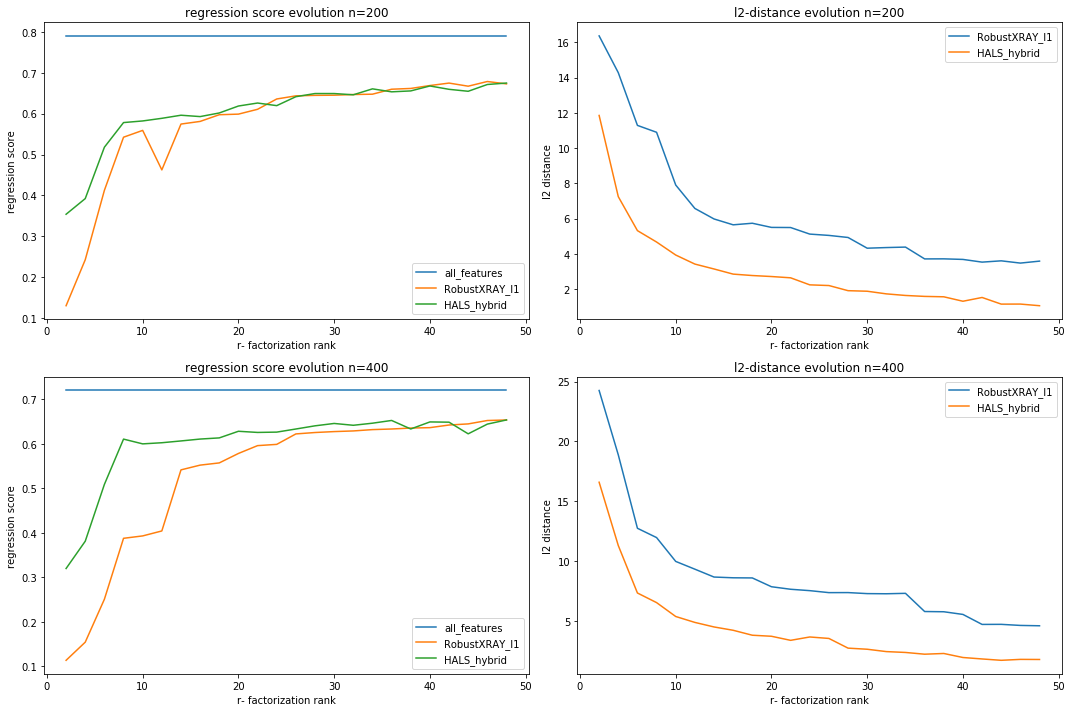

In [42]:
###NMF algorithms ####
#We register regression score and l2 distance evolutions for NMF provided by both algorithms.
#We also normalized features to sum to 1 which led to same results

r_maxes = range(2,50,2)
number_of_observations=[200,400] #[200,400]
scores=[]
plt.figure(figsize=(15,10))
for j in range(len(number_of_observations)):
    y=np.array(df.iloc[:number_of_observations[j],-1])
    X=np.array(df.iloc[:number_of_observations[j],:-1])
    print(X.shape)
    reg = LinearRegression().fit(X, y)
    scores.append( reg.score(X, y))
    Kumar_distances,HALS_distances=[],[]
    Kumar_scores,HALS_scores=[],[]
    for r in tqdm(r_maxes):
        F,W,R=RobustXRAY_l1(X,r,"max",opti=1)
        reg = LinearRegression().fit(F, y)
        Kumar_distances.append(np.linalg.norm(X-np.dot(F,W),2));Kumar_scores.append(reg.score(F, y))
        d,f,w=GillisGlineur_HALS_hybrid(X.T,r,'0','0',10**(-16),10**3,0.5,0.1,-1)#for 10000 steps
        reg = LinearRegression().fit(w.T, y)
        HALS_distances.append(d[-1]);HALS_scores.append(reg.score(w.T, y))
    plt.subplot(len(number_of_observations), 2, j*len(number_of_observations) +1)
    plt.plot(r_maxes, [scores[j]]*(len(r_maxes)))
    plt.plot(r_maxes, Kumar_scores)
    plt.plot(r_maxes, HALS_scores)
    plt.legend(['all_features','RobustXRAY_l1','HALS_hybrid'])
    plt.title('regression score evolution n={0}'.format(number_of_observations[j]))
    plt.xlabel('r- factorization rank')
    plt.ylabel('regression score')
    plt.subplot(len(number_of_observations), 2, j*len(number_of_observations) +2)
    plt.plot(r_maxes, Kumar_distances)
    plt.plot(r_maxes, HALS_distances)
    plt.legend(['RobustXRAY_l1','HALS_hybrid'])
    plt.title('l2-distance evolution n={0}'.format(number_of_observations[j]))
    plt.xlabel('r- factorization rank')
    plt.ylabel('l2 distance')
plt.tight_layout()
plt.show()




**Analysis**

- Rather efficient feature selections or dimension reduction but require tuning of hyperparameter $r$.
- HALS outperforms XRAY in terms of distance between matrix and its factorization, but not necessarily in terms related to the regression task.

### II.2.b) Discussion on other machine learning tasks

**Classification/Regression**
For these two closely related tasks, NMF works in the same way as features selection or dimension reduction (depending on presence of near-separability assumption in algorithms). So you can refer to the previous part for classification.

**Clustering / Recommandation system**

Potential applications of NMF in clustering or recommandation system were discussed with the early research of the technique. While initial findings with NMF yielded parts-based
representations and sparser encodings, dense and holistic representations were
also demonstrated. This led to the pursuit of factorizing for **sparser representations** which is necessary to bring efficient solutions for these tasks with NMF. Indeed, sparser representations have a direct link to interpretability in clustering. When one of the factorizing matrices is to be used for cluster assignment, interpreting that matrix requires row-wise sparsity, or near-orthogonality. Which has been enforced in a lot of algorithms considering different regularization schemes over $F$ and $W$. 

In fact clustering and lower rank approximation are related but their performances may be very different. If we look at objective functions for K-means:
$$min \sum_{i=1}^n ||X_i - w_{\sigma_i}||_2^2 = min || X - FW||_2^2$$
with $\sigma_i = j$ when i-th point is assigned to j-th cluster $j \in [r]$.
Therefore K-means see $F$ as $r$ cluster centroids and W as cluster membership indicator, while NMF sees $F$ as basis vectors for rank $r$ approximation and $W$ as a $r$-dimensional representation of $X$.

Once more, efficiency of these algorithms depends on data structure. A sparse NMF tries to find $r$ linearly independant cluster representatives behaving more like 'spherical clustering'.

<img src="clustering.PNG">

The analogy with recommandation system is naturally brought by its natural formulation as graph clustering. If we consider $S$ as pairwise similarity matrix, spectral clustering which relies on the eigen-structure of $S$ is commonly used. Researchers have introduced *Symmetric NMF*, to efficiently answer this task and enforce near-orthogonality with a solution independant of eigenvectors and with a more natural interpretation, aiming to solve the following problem: $$ \min_{H \geq 0} ||S-HH^T||_2^2$$

<img src="graph_clustering.PNG">
